In [1]:
# A notebook for training a policy based agent using episodes playing a virtual game
import sys, random, os, math, time, itertools
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('../app')
from config import Config

%matplotlib inline

In [116]:
class Policy:
    def __init__(self):
        self.epsilon = 1e-10
        self.high_level_actions = [
            'wait', #if stunned
            'random', #a valid strategy
           'go_opponent_flag',  #go get the flag
           'go_team_flag_area',  #especially if you have the flag
           'go_opponent_flag_carrier', #tag flag carrier
           'go_nearest_opponent', #chase
           'go_nearest_teammate', #a good choice if you have the flag
           'go_nearest_incapacitated_teammate', #revive them
           'gaurd_nearest_teammate',  #get between nearest teammate and enemy
           'gaurd_teammate_flag_carrier', #get between flag carrying teammate and enemy
           'gaurd_team_flag_area', #get between flag area and enemy
           'guard_opponent_flag_area',  #especially if opponent is running the flag
           'run_away_from_nearest_opponent',  #if being chased
           'run_away_from_opponents_centroid' #allows skirting dangerous areas
          ]
        
        self.high_level_states = ['opponents_flag_in_play', 
                                  'team_flag_in_play', 
                                  'self_incapacitated', 
                                  'self_has_flag', 
                                  'self_in_enemy_territory',
                                  'nearest_teammate_has_flag',
                                  'nearest_teammate_incapacitated', 
                                  'nearest_opponent_has_flag',
                                  'nearest_opponent_incapacitated'
                                 ]
        self.state_probs = {}
        #if os.path.exists('state_probs.pkl'):
        #    with open('state_probs.pkl', 'rb') as o:
        #        self.state_probs = pickle.load(o)
        
        if self.state_probs:
            self.high_level_state_codes = list(self.state_probs.keys())
        else: #every possible state
            self.high_level_state_codes = [tuple([int(s) for s in seq]) for seq in itertools.product('01', repeat=len(self.high_level_states))]
        
        self.q = np.zeros((len(self.high_level_state_codes), len(self.high_level_actions)))
        self.q*=-9999

        self.prev_hla = 'random'
        
        
    def get_high_level_action(self, player, the_map):
        '''Get a high level action for the player based on high level percepts'''
        #this should only be called for live players, not incapacitated players, but we'll check
        if player.is_incapacitated:
            return 'wait'
        
        #Create high level state from percept derived from player and map state
        high_level_state = self.get_high_level_state(player, the_map)
        
        #this could be a never encountered before hls, if so, just return previous hla
        if high_level_state not in self.high_level_state_codes:
            print('New state found: ', high_level_state)
            return self.prev_hla
        
        state_idx = self.high_level_state_codes.index(high_level_state)
        
        #select best action with probability proportional to utility
        action_utilities = {}
        
        #hla = high level action
        for hla in self.get_available_hlas(player, the_map, high_level_state):
            action_idx = self.high_level_actions.index(hla)
            value = self.q[state_idx, action_idx]
            action_utilities[hla] = value
            
        #normalize to positives
        min_val = min(action_utilities.values())
        action_utilities = {hla:v-min_val+self.epsilon for hla,v in action_utilities.items()}
        
        actions = [k for k in action_utilities.keys()]
        scale = sum(action_utilities.values())
        probs = [v/scale for v in action_utilities.values()]
        
        idx = np.random.choice(len(actions), p=probs)
        
        hla = actions[idx]
        self.prev_hla = hla
        
        return hla
    
    
    def get_high_level_state(self, player, the_map):
        '''Determine which high level state applies at this time'''
        state = [0 for i in range(len(self.high_level_states))]
        
        #if player is incapacitated, that is all that matters, this saves making pointless states
        if player.is_incapacitated:
            state[self.high_level_states.index('self_incapacitated')] = 1   
            return tuple(state)
        
        if (player.team=='blue' and the_map.red_flag_in_play) or (player.team=='red' and the_map.blue_flag_in_play):
            state[self.high_level_states.index('opponents_flag_in_play')] = 1
        if (player.team=='blue' and the_map.blue_flag_in_play) or (player.team=='red' and the_map.red_flag_in_play):
            state[self.high_level_states.index('team_flag_in_play')] = 1
        if player.has_flag:
            state[self.high_level_states.index('self_has_flag')] = 1
        if player.in_enemy_territory:
            state[self.high_level_states.index('self_in_enemy_territory')] = 1
            
        teammate_player = the_map.get_closest_player_by_team(player, player.team)
        if teammate_player.has_flag:
            state[self.high_level_states.index('nearest_teammate_has_flag')] = 1
        if teammate_player.is_incapacitated:
            state[self.high_level_states.index('nearest_teammate_incapacitated')] = 1
        
        opponent_player = the_map.get_closest_player_by_team(player, 'red' if player.team=='blue' else 'blue')
        if opponent_player.has_flag:
            state[self.high_level_states.index('nearest_opponent_has_flag')] = 1
        if opponent_player.is_incapacitated:
            state[self.high_level_states.index('nearest_opponent_incapacitated')] = 1
            
        return tuple(state)
            
        
    def get_available_hlas(self, player, the_map, high_level_state):
        '''Determine possible high level actions given the high level state'''
        #almost all hlas are possible except the two dependent on the flag being carried
        if player.is_incapacitated:
            return ['wait']
        
        hlas = self.high_level_actions.copy()
        hlas.remove('go_opponent_flag_carrier')
        hlas.remove('gaurd_teammate_flag_carrier')
        hlas.remove('go_nearest_incapacitated_teammate')
        
        if (player.team=='blue' and the_map.blue_flag_in_play) or (player.team=='red' and not the_map.red_flag_in_play):
            hlas.append('go_opponent_flag_carrier')
        if (player.team=='blue' and the_map.red_flag_in_play) or (player.team=='red' and not the_map.blue_flag_in_play):
            hlas.append('gaurd_teammate_flag_carrier')
        if high_level_state[self.high_level_states.index('nearest_teammate_incapacitated')]==1:
            hlas.append('go_nearest_incapacitated_teammate')
            
        return hlas

In [117]:
class VirtualMap():
    def __init__(self, config):
        self.players = []
        
        self.tile_speeds = np.load(config.map_default_speed_array)
        #idx = np.where(self.tile_speeds==0)
        idx = np.where(self.tile_speeds[1:-1,1:-1]==0)
        #we're not learning at tile level so remove obstacles
        self.tile_speeds[idx] = 1.0
        #self.not_allowed = list(zip(idx[0].tolist(), idx[1].tolist()))
        self.middle_tile = self.tile_speeds.shape[1]//2
        
        #flags
        blue_flag_x = 5
        col_speeds = self.tile_speeds[:, blue_flag_x]
        idx = np.where(col_speeds > 0)[0].tolist()
        blue_flag_y = random.choice(idx[2:-2])
        self.blue_flag_xy = (blue_flag_x, blue_flag_y)
        if config.verbose:
            print('blue flag xy', self.blue_flag_xy)
        
        red_flag_x = self.tile_speeds.shape[1] - blue_flag_x
        col_speeds = self.tile_speeds[:, red_flag_x]
        idx = np.where(col_speeds > 0)[0].tolist()
        red_flag_y = random.choice(idx[2:-2])
        self.red_flag_xy = (red_flag_x, red_flag_y)
        if config.verbose:
            print('red flag xy', self.red_flag_xy)
        
        self.blue_flag_area = [(x,y) for x in range(self.blue_flag_xy[0]-2, self.blue_flag_xy[0]+3) for y in range(self.blue_flag_xy[1]-2, self.blue_flag_xy[1]+3)]
        self.red_flag_area = [(x,y) for x in range(self.red_flag_xy[0]-2, self.red_flag_xy[0]+3) for y in range(self.red_flag_xy[1]-2, self.red_flag_xy[1]+3)]
        self.blue_flag_in_play = False
        self.red_flag_in_play = False
        
        
    def get_closest_player_by_team(self, player, team):
        best_dist=float('inf')
        best_player = None
        x1, y1 = player.xy
        
        for other_player in self.players:
            if other_player.player_idx==player.player_idx or not other_player.team==team:
                continue
                
            x2, y2 = other_player.xy
            dist = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
            if dist<best_dist:
                best_player = other_player
                
        return best_player
    
    
    def get_closest_player_to_xy_by_team(self, player, xy, team):
        best_dist=float('inf')
        best_player = None
        x1, y1 = xy
        for other_player in self.players:
            if other_player.player_idx==player.player_idx or not other_player.team==team:
                continue
                
            x2, y2 = other_player.xy
            dist = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
            if dist<best_dist:
                best_player = other_player
                
        return best_player
    
    
    def get_closest_incapacitated_player_by_team(self, player, team):
        best_dist=float('inf')
        best_player = None
        x1, y1 = player.xy
        
        for other_player in self.players:
            if other_player.player_idx==player.player_idx or not other_player.team==team or not other_player.is_incapacitated:
                continue
                
            x2, y2 = other_player.xy
            dist = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
            if dist<best_dist:
                best_player = other_player
                
        return best_player
    
    
    #copied from Player
    def get_direction_to_xy(self, xy1, xy2):
        x1,y1 = xy1
        x2,y2 = xy2
        delta_x, delta_y = x2 - x1, y2 - y1
        if abs(delta_x)>abs(delta_y):
            return 'a' if delta_x<0 else 'd'
        else:
            return 'w' if delta_y<0 else 's'
        
        
    def get_direction_away_from(self, xy1, xy2):
        x1,y1 = xy1
        x2,y2 = xy2
        delta_x, delta_y = x1 - x2, y1 - y2
        if abs(delta_x)<abs(delta_y):
            return 'a' if delta_x<0 else 'd'
        else:
            return 'w' if delta_y<0 else 's'
        
        
    def go_between(self, xy1, xy2):
        x1,y1 = xy1
        x2,y2 = xy2
        midx, midy = x1 + ((x2 - x1)/2), y1 + ((y2 - y1)/2)
        return self.get_direction_to_xy(xy1, (midx, midy))
    
        
        
class VirtualPlayer():
    def __init__(self, team, idx, the_map, xy):
        self.team = team
        self.player_idx = idx
        self.the_map = the_map
        self.has_flag = False
        self.is_incapacitated = False
        self.incapacitated_countdown = 0
        self.in_enemy_territory = False
        self.in_flag_area = False
        self.xy = xy
        self.prev_dir = random.choice(['a','w','s','d'])
        #for penalties
        self.got_tagged = False
        self.got_tagged_with_flag = False
        self.teammate_got_flag = False
        self.opponent_got_flag = False
        self.lost = False
        self.won = False
        
        
        
class VirtualGame():
    def __init__(self, config):
        self.verbose = config.verbose
        self.the_map = VirtualMap(config)
        team_size = config.blue_team_size
        
        #put players in the map
        side = self.the_map.tile_speeds.shape[1]//3
        for team in ['blue', 'red']:
            if team=='blue':
                idx = np.where(self.the_map.tile_speeds[:,:side]>0)
            else:
                idx = np.where(self.the_map.tile_speeds[:,(side*2):]>0)
                idx = (idx[0], idx[1] + np.ones_like(idx[1]) * (side*2))
            allowed_init_tiles = list(zip(idx[0].tolist(), idx[1].tolist()))
            random.shuffle(allowed_init_tiles)
        
            for i in range(team_size):
                y, x = allowed_init_tiles.pop()
                if self.verbose:
                    print('%s player %d at (%d, %d)' % (team, i, x, y))
                player = VirtualPlayer(team, i, self.the_map, (x, y))
                self.the_map.players.append(player)
                
        #rewards
        #movement reward is speed value - 5
        self.stationary_reward = -1 #-5
        
        self.got_tagged_reward = -5 #-10
        self.got_tagged_with_flag_reward = -20 #-50
        self.tagged_reward = 5 #20
        self.tagged_flag_holder_reward = 20 #50
        
        self.revived_teammate_reward = 5 #25
        self.got_flag_reward = 30 #50
        self.teammate_got_flag_reward = 10 #30
        self.opponent_got_flag_reward = -10 #-30
        
        self.lost_reward = -1000 #-1000
        self.won_reward = 1000 #1000
        
        if self.verbose:
            for r in range(self.the_map.tile_speeds.shape[0]):
                row=[]
                for c in range(self.the_map.tile_speeds.shape[1]):
                    s = str(self.the_map.tile_speeds[r,c])
                    if self.the_map.blue_flag_xy==(c,r):
                        s = 'BF'
                    elif self.the_map.red_flag_xy==(c,r):
                        s = 'RF'
                    for player in self.the_map.players:
                        if player.xy==(c,r):
                            s = 'B-%d' % player.player_idx if player.team=='blue' else 'R-%d' % player.player_idx
                            break
                    row.append(s)
                print(',   '.join(row))
                    
            
    def step(self, player, hla):
        if self.verbose:
            print('%s player %d at %s has HLA %s' % (player.team, player.player_idx, str(player.xy), hla))
            
        #execute a game step for a player using high level action and policy
        opponent_team = 'red' if player.team=='blue' else 'blue'
        
        #apply any outstanding penalties caused by another player
        if player.got_tagged:
            player.got_tagged = False
            if self.verbose:
                print('\ttagged')
            return self.got_tagged_reward, False
        elif player.got_tagged_with_flag:
            player.got_tagged_with_flag = False
            if self.verbose:
                print('\ttagged with flag')
            return self.got_tagged_with_flag_reward, False
        elif player.teammate_got_flag:
            player.teammate_got_flag = False
            if self.verbose:
                print('\tteammate got flag')
            return self.teammate_got_flag_reward, False
        elif player.opponent_got_flag:
            player.opponent_got_flag = False
            if self.verbose:
                print('\topponent got flag')
            return self.opponent_got_flag_reward, False
        elif player.lost:
            if self.verbose:
                print('\tteam lost')
            return self.lost_reward, True
        elif player.won:
            if self.verbose:
                print('\tteam won')
            return self.won_reward, True
        
        
        if player.is_incapacitated:
            player.incapacitated_countdown -= 1
            #is countdown over?
            if player.incapacitated_countdown<=0:
                if self.verbose:
                    print('\tno longer incapacitated')
                player.is_incapacitated = False
            else:
                if self.verbose:
                    print('\tstill incapacitated for %d rounds' % (player.incapacitated_countdown))
            return self.stationary_reward, False
        
        
        action = self.__hla_to_direction(player, hla)
        if self.verbose:
            print('\tlow level action %s' % (action))
                
        #apply direction if possible
        player_x, player_y = player.xy
        new_xy = player.xy
        speed = 0
        #tile speeds is row by col, which equals y by x
        if action=='w' and (player_y-1, player_x):# not in self.the_map.not_allowed:
            new_xy = (player_x, player_y-1)
            speed = self.the_map.tile_speeds[player_y-1, player_x]
        elif action=='s' and (player_y+1, player_x):# not in self.the_map.not_allowed:
            new_xy = (player_x, player_y+1)
            speed = self.the_map.tile_speeds[player_y+1, player_x]
        elif action=='a' and (player_y, player_x-1):# not in self.the_map.not_allowed:
            new_xy = (player_x-1, player_y)
            speed = self.the_map.tile_speeds[player_y, player_x-1]
        elif action=='d' and (player_y, player_x+1):# not in self.the_map.not_allowed:
            new_xy = (player_x+1, player_y)
            speed = self.the_map.tile_speeds[player_y, player_x+1]
        
        
        #if the player didn't move
        if not speed:
            if self.verbose:
                print('\tspeed is 0 at desired position')
            return self.stationary_reward, False
        
        
        #update position
        player.xy = new_xy
        if self.verbose:
            print('\tnew position: %s, speed %d' % (str(player.xy), speed))
            
        if player.team=='blue':
            if player.xy[0]>self.the_map.middle_tile and not player.in_enemy_territory:
                if self.verbose:
                    print('\tplayer entered enemy territory')
                player.in_enemy_territory=True
            elif player.xy[0]<self.the_map.middle_tile and player.in_enemy_territory:
                if self.verbose:
                    print('\tplayer exitted enemy territory')
                player.in_enemy_territory=False
        if player.team=='red':
            if player.xy[0]<self.the_map.middle_tile and not player.in_enemy_territory:
                if self.verbose:
                    print('\tplayer entered enemy territory')
                player.in_enemy_territory=True
            elif player.xy[0]>self.the_map.middle_tile and player.in_enemy_territory:
                if self.verbose:
                    print('\tplayer exitted enemy territory')
                player.in_enemy_territory=False
                
        
        #player won
        if player.team=='blue' and player.has_flag and new_xy in self.the_map.blue_flag_area:
            for other_player in self.the_map.players:
                if other_player.player_idx==player.player_idx:
                    continue
                if other_player.team==opponent_team:
                    other_player.lost = True
                else:
                    other_player.won = True
            #add rewards for other players AFTER the end signal is sent in order to award/penalize all players
            if self.verbose:
                print('\tplayer won')
            return self.won_reward, True
        elif player.team=='red' and player.has_flag and new_xy in self.the_map.red_flag_area:
            for other_player in self.the_map.players:
                if other_player.player_idx==player.player_idx:
                    continue
                if other_player.team==opponent_team:
                    other_player.lost = True
                else:
                    other_player.won = True
            if self.verbose:
                print('\tplayer won')
            return self.won_reward, True
        
        
        #player got flag
        if new_xy==self.the_map.red_flag_xy and player.team=='blue' and not self.the_map.red_flag_in_play:
            player.has_flag = True
            self.the_map.red_flag_in_play = True
            for other_player in self.the_map.players:
                if other_player.player_idx==player.player_idx:
                    continue
                if other_player.team==opponent_team:
                    other_player.opponent_got_flag = True
                else:
                    other_player.teammate_got_flag = True
            if self.verbose:
                print('\tplayer got flag')
            return self.got_flag_reward, False
        
        if new_xy==self.the_map.blue_flag_xy and player.team=='red' and not self.the_map.blue_flag_in_play:
            player.has_flag = True
            self.the_map.blue_flag_in_play = True
            for other_player in self.the_map.players:
                if other_player.player_idx==player.player_idx:
                    continue
                if other_player.team==opponent_team:
                    other_player.opponent_got_flag = True
                else:
                    other_player.teammate_got_flag = True
            if self.verbose:
                print('\tplayer got flag')
            return self.got_flag_reward, False
        
        
        #player tagged someone
        for other_player in self.the_map.players:
            #skip self
            if other_player.player_idx==player.player_idx:
                continue
                
            if not other_player.xy==new_xy:
                continue
                
            if other_player.team==opponent_team and not other_player.is_incapacitated:
                #you tagged other player
                if other_player.in_enemy_territory or other_player.has_flag:
                    other_player.is_incapacitated = True
                    other_player.incapacitation_countdown = 10
                    if other_player.has_flag:
                        other_player.has_flag = False
                        other_player.got_tagged_with_flag = True
                        if other_player.team=='blue':
                            self.the_map.red_flag_in_play = False
                        else:
                            self.the_map.blue_flag_in_play = False
                        if self.verbose:
                            print('\tplayer tagged %s-%d' % (other_player.team, other_player.player_idx))
                        return self.tagged_flag_holder_reward, False
                    else:
                        other_player.got_tagged = True
                        if self.verbose:
                            print('\tplayer tagged flag carrier %s-%d' % (other_player.team, other_player.player_idx))
                        return self.tagged_reward, False
                #other player tagged you
                elif player.in_enemy_territory or player.has_flag:
                    player.is_incapacitated = True
                    player.incapacitation_countdown = 5
                    if player.has_flag:
                        player.has_flag = False
                        if player.team=='blue':
                            self.the_map.red_flag_in_play = False
                        else:
                            self.the_map.blue_flag_in_play = False
                        if self.verbose:
                            print('\tplayer tagged %s-%d' % (player.team, player.player_idx))
                        return self.got_tagged_with_flag_reward, False
                    return self.got_tagged_reward, False
            #revived teammate?
            elif other_player.team==player.team and other_player.is_incapacitated:
                other_player.is_incapacitated = False
                other_player.incapacitation_countdown = 0
                if self.verbose:
                    print('\tplayer revived %s-%d' % (other_player.team, other_player.player_idx))
                return self.revived_teammate_reward, False
            
        #player just moved
        #return speed - 5, False
        return -1, False
    
    
    #copied from policy agent
    def __hla_to_direction(self, player, hla):
        action = ''
        team = 'blue' if player.team=='blue' else 'red'
        opponent_team = 'red' if player.team=='blue' else 'blue'
        xy1 = player.xy
        
        if hla=='wait':
            return ''
        elif hla=='random':
            if random.randint(1,20) == 1:
                player.prev_dir = random.choice(['a','w','s','d'])
            action = player.prev_dir
        elif hla=='go_opponent_flag':
            xy2 = self.the_map.red_flag_xy if team=='blue' else self.the_map.blue_flag_xy
            action = self.the_map.get_direction_to_xy(xy1, xy2)
        elif hla=='go_team_flag_area':
            xy2 = self.the_map.blue_flag_xy if team=='blue' else self.the_map.red_flag_xy
            action = self.the_map.get_direction_to_xy(xy1, xy2)
        elif hla=='go_opponent_flag_carrier':
            for other_player in self.the_map.players:
                if not (other_player.team==opponent_team and other_player.has_flag):
                    continue
                action = self.the_map.get_direction_to_xy(xy1, other_player.xy)
                break
        elif hla=='go_nearest_opponent':
            other_player = self.the_map.get_closest_player_by_team(player, opponent_team)
            action = self.the_map.get_direction_to_xy(xy1, other_player.xy)
        elif hla=='go_nearest_teammate':
            other_player = self.the_map.get_closest_player_by_team(player, team)
            action = self.the_map.get_direction_to_xy(xy1, other_player.xy)
        elif hla=='go_nearest_incapacitated_teammate':
            other_player = self.the_map.get_closest_incapacitated_player_by_team(player, team)
            action = self.the_map.get_direction_to_xy(xy1, other_player.xy)
        elif hla=='gaurd_nearest_teammate':
            other_player = self.the_map.get_closest_player_by_team(player, team)
            opponent_player = self.the_map.get_closest_player_to_xy_by_team(player, other_player.xy, opponent_team)
            action = self.the_map.go_between(other_player.xy, opponent_player.xy)
        elif hla=='gaurd_teammate_flag_carrier':
            for other_player in self.the_map.players:
                if not (other_player.team==player.team and other_player.has_flag):
                    continue
                opponent_player = self.the_map.get_closest_player_to_xy_by_team(player, other_player.xy, opponent_team)
                action = self.the_map.get_direction_to_xy(opponent_player.xy, other_player.xy)
                break
        elif hla=='gaurd_team_flag_area':
            xy2 = self.the_map.blue_flag_xy if team=='blue' else self.the_map.red_flag_xy
            other_player = self.the_map.get_closest_player_to_xy_by_team(player, xy2, opponent_team)
            action = self.the_map.go_between(other_player.xy, xy2)
        elif hla=='guard_opponent_flag_area':
            xy2 = self.the_map.red_flag_xy if team=='blue' else self.the_map.blue_flag_xy
            other_player = self.the_map.get_closest_player_to_xy_by_team(player, xy2, opponent_team)
            action = self.the_map.go_between(other_player.xy, xy2)
        elif hla=='run_away_from_nearest_opponent':
            other_player = self.the_map.get_closest_player_by_team(player, opponent_team)
            action = self.the_map.get_direction_away_from(xy1, other_player.xy)
        elif hla=='run_away_from_opponents_centroid':
            xs, ys = [],[]
            for other_player in self.the_map.players:
                if not other_player.team==opponent_team:
                    continue
                xs.append(other_player.xy[0])
                ys.append(other_player.xy[1])
            mean_xy = (sum(xs)/len(xs), sum(ys)/len(ys))
            action = self.the_map.get_direction_away_from(xy1, mean_xy)
            
        return action

In [118]:
#For debugging virtual game play
def debug():
    policy = Policy()
    config = Config(verbose=True)
    config.blue_team_size = 2
    config.red_team_size = 2
    game = VirtualGame(config)
    player_prev_state_action = {'%s-%d' % (p.team, p.player_idx):(None,None) for p in game.the_map.players}
    state_cts = {}
    game_over = False
    skip_team_idx = ()
    final_scores = False

    for i in range(100):
        print('\n\nStep %d' % i)
        for player in game.the_map.players:
            if game_over and skip_team_idx and skip_team_idx==(player.team, player.player_idx):
                final_scores = True
                continue

            idx = '%s-%d' % (player.team, player.player_idx)
            prev_state, prev_action = player_prev_state_action[idx]

            state = policy.get_high_level_state(player, game.the_map)

            if state==prev_state:
                action = prev_action
            else:
                action = random.choice(policy.get_available_hlas(player, game.the_map, state))
                player_prev_state_action[idx] = (state, action)

                print('\nHigh level state:')
                for j in range(len(state)):
                    if state[j]:
                        print('   %s' % policy.high_level_states[j])

                if not state in state_cts:
                    state_cts[state]=0
                state_cts[state]+=1

            reward, game_over = game.step(player, action)
            print('Reward: %d, Game over: %s' % (reward, game_over))

            new_state = policy.get_high_level_state(player, game.the_map)
            if not new_state==state:
                print('New high level state')

            if game_over:
                if not skip_team_idx:
                    skip_team_idx=(player.team, player.player_idx)
                    break

        if game_over and final_scores:
            break

    print('\n\n\n')
    for st,ct in state_cts.items():
        print(st, ct)

In [119]:
class PolicyTrainer():
    def __init__(self, policy, config):
        self.policy = policy
        self.config = config
        self.discount = 0.8
        self.alpha = 0.1
        self.episodes = 10000
        
        
    def train(self):
        deltas = []
        ep_deltas = []
        state_cts = {}
        state_to_monitor1 = (1,0,0,1,0,0,0,0,0) #''opponents_flag_in_play, 'self_has_flag'
        state_to_monitor2 = (0,1,0,0,0,0,0,1,0) #opponent has flag and is near
        monitor_idx1 = self.policy.high_level_state_codes.index(state_to_monitor1)
        monitor_idx2 = self.policy.high_level_state_codes.index(state_to_monitor2)
        
        #each episode
        for i in range(self.episodes):
            if i and i%10==0:        
                deltas.append(sum(ep_deltas)/len(ep_deltas))  
                ep_deltas = []
                
            if i and i%50==0:
                print('\nepisode', i)
                print('\nyou have flag')
                for j in range(len(self.policy.high_level_actions)):
                    print('%s\t\t\t%.4f' % (self.policy.high_level_actions[j], self.policy.q[monitor_idx1,j]))
                print('\nopponent has flag and is close:')
                for j in range(len(self.policy.high_level_actions)):
                    print('%s\t\t\t%.4f' % (self.policy.high_level_actions[j], self.policy.q[monitor_idx2,j]))
                self.__plot(deltas)
                np.save('q.npy', self.policy.q)
                with open('state_counts.txt', 'w') as o:
                    o.write('%s\n' % '\t'.join(self.policy.high_level_states))
                    for st,ct in state_cts.items():
                        o.write('%s\t%d\n' % ('\t'.join([str(s) for s in st]), ct))
                
            #create virtual game, map, and players
            game = VirtualGame(self.config)
            
            #when game is over, do one more pass over players, skipping the person who won the game and was rewarded
            game_over = False
            skip_team_idx = ()
            final_scores = False
            
            #track if the state has changed for a player and only choose new HLA then
            player_prev_state_action = {'%s_%d' % (p.team, p.player_idx):(None,None) for p in game.the_map.players}
            
            new_q = self.policy.q.copy()
            for j in range(10000): #cut game off after x steps
                random.shuffle(game.the_map.players)
                for player in game.the_map.players:
                    idx = '%s_%d' % (player.team, player.player_idx)
                    prev_state, prev_action = player_prev_state_action[idx]
                    
                    if game_over and skip_team_idx and skip_team_idx==(player.team, player.player_idx):
                        #flag that we're assigning final scores
                        final_scores = True
                        continue
                        
                    #get game state for this player
                    state = self.policy.get_high_level_state(player, game.the_map)
                
                    if not state in state_cts:
                        state_cts[state]=0
                    state_cts[state]+=1
                
                    #only choose new action if state has changed for this player
                    if state==prev_state:
                        action = prev_action
                        #print('using prev action', action)
                    #elif random.random()<(i/self.episodes):
                    #    action = self.choose_action_by_policy(player, game.the_map, state)
                        #print('choosing action by policy', action)
                    else:
                        #explore actions: For each state, select any one among all possible actions for the current state (S).
                        action = random.choice(self.policy.get_available_hlas(player, game.the_map, state))
                        #update player state, action
                        player_prev_state_action[idx] = (state, action)
                        #print('choosing random action', action)

                    #execute the hla and get the immediate reward for the new state
                    reward, game_over = game.step(player, action)
                    
                    #Travel to the next state (S') as a result of that action (a).
                    new_state = self.policy.get_high_level_state(player, game.the_map)

                    #For all possible actions from the state (S') select the one with the highest Q-value.
                    best_action = ''
                    best_value = -float('inf')
                    for pos_action in self.policy.get_available_hlas(player, game.the_map, new_state):
                        new_state_idx = self.policy.high_level_state_codes.index(new_state)
                        pos_action_idx = self.policy.high_level_actions.index(pos_action)
                        value = self.policy.q[new_state_idx, pos_action_idx]
                        if value>best_value:
                            best_action = pos_action
                            best_value = value

                    #get previous Q value for computing delta
                    state_idx = self.policy.high_level_state_codes.index(state)
                    action_idx = self.policy.high_level_actions.index(action)
                    prev_val = self.policy.q[state_idx, action_idx]

                    #calculate the utility
                    utility = (1 - self.alpha)* prev_val + self.alpha*(reward + self.discount*best_value)
                    new_q[state_idx, action_idx] = utility

                    #store the delta for plotting
                    ep_deltas.append(abs(new_q[state_idx, action_idx] - prev_val))

                    #Set the next state as the current state.
                    state = new_state

                    #If goal state is reached, then end and repeat the process.
                    if game_over:
                        if not skip_team_idx:
                            skip_team_idx=(player.team, player.player_idx)
                            break
                
                #has the last pass to assign final scores occurred?
                if game_over and final_scores:
                    print('game completed at', j)
                    #should q only be updated after a completed game?
                    self.policy.q = new_q
                    break
                    
        print(len(state_cts))
        for st,ct in state_cts.items():
            print(st, ct)
        self.__plot(deltas)
        
    
    def choose_action_by_policy(self, player, the_map, high_level_state):
        if high_level_state not in self.policy.high_level_state_codes:
            print('New state found: ', high_level_state)
            return self.policy.prev_hla
        state_idx = self.policy.high_level_state_codes.index(high_level_state)
            
        action_utilities = {}
        
        #hla = high level action
        best_hla=''
        best_score=-float('inf')
        for hla in self.policy.get_available_hlas(player, the_map, high_level_state):
            action_idx = self.policy.high_level_actions.index(hla)
            value = self.policy.q[state_idx, action_idx]
            action_utilities[hla] = value
            if value>best_score:
                best_score=value
                best_hla = hla
        
        #normalize to positives
        min_val = min(action_utilities.values())
        action_utilities = {hla:v-min_val+1e-10 for hla,v in action_utilities.items()}
        
        #choose probabilistically or not
        if random.random()<0.2:
            actions = [k for k in action_utilities.keys()]
            scale = sum(action_utilities.values())
            probs = [v/scale for v in action_utilities.values()]
            idx = np.random.choice(len(actions), p=probs)
            hla = actions[idx]
        else:
            hla = best_hla
            
        return best_hla
        
        
    def __plot(self, x, path=''):
        fig, ax = plt.subplots()
        ax.plot(x)
        ax.set(xlabel='time', ylabel='q delta', title='Q Learning deltas')
        ax.grid()
        if path:
            fig.savefig(path)
        plt.show()

game completed at 1059
game completed at 118
game completed at 3004
game completed at 2059
game completed at 4290
game completed at 1356
game completed at 7520

episode 50

you have flag
wait			7.7320
random			-0.0000
go_opponent_flag			-0.1900
go_team_flag_area			107.8320
go_opponent_flag_carrier			8.5266
go_nearest_opponent			7.7320
go_nearest_teammate			-0.0000
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			-0.0000
gaurd_teammate_flag_carrier			95.8420
gaurd_team_flag_area			16.2005
guard_opponent_flag_area			-0.0000
run_away_from_nearest_opponent			15.9163
run_away_from_opponents_centroid			28.2225

opponent has flag and is close:
wait			-0.6202
random			-59.6102
go_opponent_flag			-0.6151
go_team_flag_area			-0.6202
go_opponent_flag_carrier			-0.1000
go_nearest_opponent			-0.6202
go_nearest_teammate			-0.6202
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			-0.6202
gaurd_teammate_flag_carrier			-0.6543
gaurd_team_flag_area			-0.6202
guard_

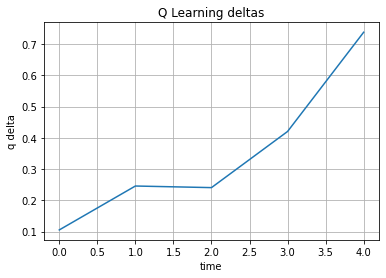

game completed at 3328
game completed at 1373
game completed at 533
game completed at 2540

episode 100

you have flag
wait			7.7320
random			-0.0000
go_opponent_flag			2.6130
go_team_flag_area			297.4326
go_opponent_flag_carrier			8.5266
go_nearest_opponent			7.7320
go_nearest_teammate			2.7840
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			2.7840
gaurd_teammate_flag_carrier			95.8420
gaurd_team_flag_area			30.5974
guard_opponent_flag_area			-0.0000
run_away_from_nearest_opponent			15.9163
run_away_from_opponents_centroid			28.2225

opponent has flag and is close:
wait			-0.9049
random			-39.6082
go_opponent_flag			-0.9015
go_team_flag_area			-0.9049
go_opponent_flag_carrier			-0.1980
go_nearest_opponent			-0.9049
go_nearest_teammate			-0.9049
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			-0.9049
gaurd_teammate_flag_carrier			-0.9038
gaurd_team_flag_area			-0.9049
guard_opponent_flag_area			-0.9015
run_away_from_nearest_opponent			-0.9049
r

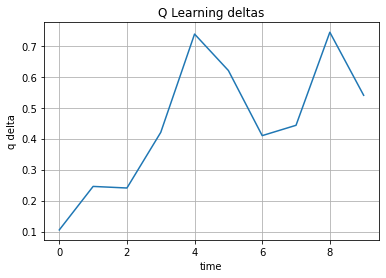

game completed at 529
game completed at 4627
game completed at 1511
game completed at 76
game completed at 358

episode 150

you have flag
wait			79.4121
random			50.5079
go_opponent_flag			40.9440
go_team_flag_area			564.4036
go_opponent_flag_carrier			8.5266
go_nearest_opponent			7.7320
go_nearest_teammate			5.8041
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			33.7243
gaurd_teammate_flag_carrier			95.8420
gaurd_team_flag_area			30.5974
guard_opponent_flag_area			41.0388
run_away_from_nearest_opponent			59.3769
run_away_from_opponents_centroid			63.9926

opponent has flag and is close:
wait			-1.0735
random			-23.1320
go_opponent_flag			-0.5458
go_team_flag_area			-1.0735
go_opponent_flag_carrier			-0.6483
go_nearest_opponent			-90.7396
go_nearest_teammate			-1.1026
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			-1.1026
gaurd_teammate_flag_carrier			-1.0377
gaurd_team_flag_area			-1.0735
guard_opponent_flag_area			-0.8276
run_away_from_near

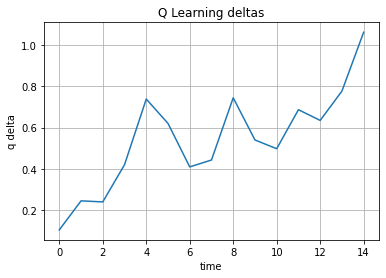

game completed at 648
game completed at 3173
game completed at 5435

episode 200

you have flag
wait			79.4121
random			54.5408
go_opponent_flag			40.9440
go_team_flag_area			564.4036
go_opponent_flag_carrier			52.7262
go_nearest_opponent			7.4588
go_nearest_teammate			5.8041
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			33.7243
gaurd_teammate_flag_carrier			95.8420
gaurd_team_flag_area			30.5974
guard_opponent_flag_area			46.0186
run_away_from_nearest_opponent			198.5915
run_away_from_opponents_centroid			63.9926

opponent has flag and is close:
wait			-1.1925
random			-17.2731
go_opponent_flag			-0.2712
go_team_flag_area			-2.0025
go_opponent_flag_carrier			-0.8052
go_nearest_opponent			-64.6233
go_nearest_teammate			-1.2137
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			-1.2137
gaurd_teammate_flag_carrier			-1.1341
gaurd_team_flag_area			-1.1925
guard_opponent_flag_area			-0.4765
run_away_from_nearest_opponent			-1.1867
run_away_from_oppo

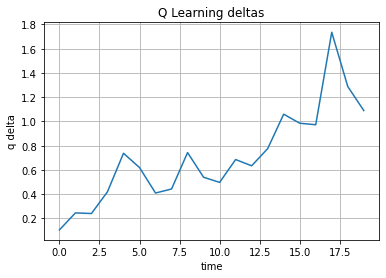

game completed at 1772
game completed at 399

episode 250

you have flag
wait			79.4121
random			201.3359
go_opponent_flag			81.9019
go_team_flag_area			653.1155
go_opponent_flag_carrier			52.7262
go_nearest_opponent			7.4588
go_nearest_teammate			50.2760
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			40.1093
gaurd_teammate_flag_carrier			131.3101
gaurd_team_flag_area			72.5899
guard_opponent_flag_area			86.4690
run_away_from_nearest_opponent			198.5915
run_away_from_opponents_centroid			63.9926

opponent has flag and is close:
wait			-101.1047
random			-114.1300
go_opponent_flag			-0.4584
go_team_flag_area			-1.8608
go_opponent_flag_carrier			-0.8464
go_nearest_opponent			-52.5837
go_nearest_teammate			-1.2218
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			-1.2218
gaurd_teammate_flag_carrier			-1.1574
gaurd_team_flag_area			-1.2047
guard_opponent_flag_area			-0.6248
run_away_from_nearest_opponent			-1.2000
run_away_from_opponents_centroid			

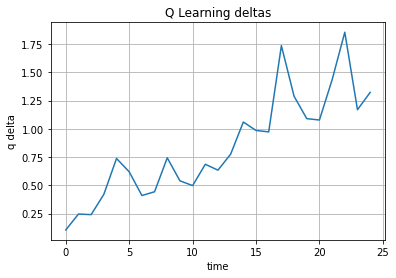

game completed at 6189
game completed at 137
game completed at 2899

episode 300

you have flag
wait			123.6201
random			201.3359
go_opponent_flag			85.9034
go_team_flag_area			825.2521
go_opponent_flag_carrier			99.6028
go_nearest_opponent			29.6884
go_nearest_teammate			197.4976
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			88.2476
gaurd_teammate_flag_carrier			131.3101
gaurd_team_flag_area			72.5899
guard_opponent_flag_area			90.0138
run_away_from_nearest_opponent			198.5915
run_away_from_opponents_centroid			69.7850

opponent has flag and is close:
wait			-74.0966
random			-83.5921
go_opponent_flag			-0.0708
go_team_flag_area			-172.5768
go_opponent_flag_carrier			-0.9662
go_nearest_opponent			-128.6348
go_nearest_teammate			-1.2820
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			-0.7468
gaurd_teammate_flag_carrier			-1.2115
gaurd_team_flag_area			-1.2695
guard_opponent_flag_area			-0.8468
run_away_from_nearest_opponent			-1.2661
run_away

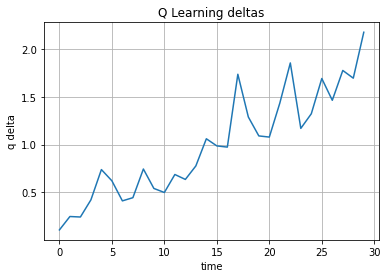

game completed at 1756

episode 350

you have flag
wait			123.6201
random			201.3359
go_opponent_flag			85.9034
go_team_flag_area			825.2521
go_opponent_flag_carrier			99.6028
go_nearest_opponent			29.6884
go_nearest_teammate			343.7680
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			88.2476
gaurd_teammate_flag_carrier			131.3101
gaurd_team_flag_area			72.5899
guard_opponent_flag_area			90.0138
run_away_from_nearest_opponent			244.6525
run_away_from_opponents_centroid			128.7267

opponent has flag and is close:
wait			-66.7926
random			-75.3385
go_opponent_flag			-0.1694
go_team_flag_area			-155.4248
go_opponent_flag_carrier			-0.9662
go_nearest_opponent			-115.8770
go_nearest_teammate			-1.2595
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			-0.7778
gaurd_teammate_flag_carrier			-1.1961
gaurd_team_flag_area			-1.2482
guard_opponent_flag_area			-0.8678
run_away_from_nearest_opponent			-1.2452
run_away_from_opponents_centroid			-11.0861


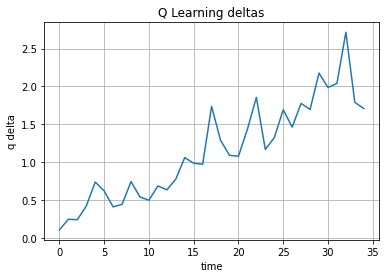

game completed at 3319
game completed at 510
game completed at 7693
game completed at 1772
game completed at 958

episode 400

you have flag
wait			177.1782
random			201.3359
go_opponent_flag			85.9034
go_team_flag_area			825.2521
go_opponent_flag_carrier			99.6028
go_nearest_opponent			92.6398
go_nearest_teammate			447.2411
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			145.3430
gaurd_teammate_flag_carrier			184.0992
gaurd_team_flag_area			231.5617
guard_opponent_flag_area			100.3832
run_away_from_nearest_opponent			244.6525
run_away_from_opponents_centroid			128.7267

opponent has flag and is close:
wait			-44.1538
random			-49.7608
go_opponent_flag			0.1469
go_team_flag_area			-102.3054
go_opponent_flag_carrier			-0.9646
go_nearest_opponent			-69.4916
go_nearest_teammate			-1.1575
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			-0.1833
gaurd_teammate_flag_carrier			-101.0511
gaurd_team_flag_area			-1.1501
guard_opponent_flag_area			-0.9005


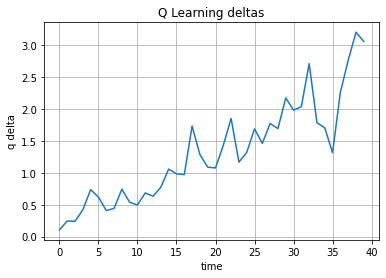

game completed at 701
game completed at 796

episode 450

you have flag
wait			225.3806
random			247.1225
go_opponent_flag			85.9034
go_team_flag_area			808.6471
go_opponent_flag_carrier			99.6028
go_nearest_opponent			92.6398
go_nearest_teammate			447.2411
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			145.3430
gaurd_teammate_flag_carrier			231.6095
gaurd_team_flag_area			231.5617
guard_opponent_flag_area			156.2650
run_away_from_nearest_opponent			244.6525
run_away_from_opponents_centroid			128.7267

opponent has flag and is close:
wait			-35.8843
random			-40.4259
go_opponent_flag			0.6314
go_team_flag_area			-82.9871
go_opponent_flag_carrier			-0.9646
go_nearest_opponent			-56.4079
go_nearest_teammate			-1.0573
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			-0.2682
gaurd_teammate_flag_carrier			-81.9711
gaurd_team_flag_area			-1.0513
guard_opponent_flag_area			-0.8491
run_away_from_nearest_opponent			-1.0497
run_away_from_opponents_centro

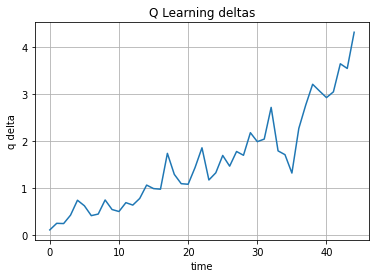

game completed at 1453
game completed at 628

episode 500

you have flag
wait			267.4343
random			246.4257
go_opponent_flag			101.3285
go_team_flag_area			792.3741
go_opponent_flag_carrier			154.2343
go_nearest_opponent			83.8758
go_nearest_teammate			467.1087
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			154.8241
gaurd_teammate_flag_carrier			231.6095
gaurd_team_flag_area			272.9973
guard_opponent_flag_area			156.2650
run_away_from_nearest_opponent			244.6525
run_away_from_opponents_centroid			128.7267

opponent has flag and is close:
wait			-29.1018
random			-32.0210
go_opponent_flag			1.9949
go_team_flag_area			-67.2551
go_opponent_flag_carrier			-0.0996
go_nearest_opponent			-44.9664
go_nearest_teammate			-0.8919
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			-0.2528
gaurd_teammate_flag_carrier			-73.8235
gaurd_team_flag_area			-0.1276
guard_opponent_flag_area			0.0362
run_away_from_nearest_opponent			-0.1263
run_away_from_opponents_cent

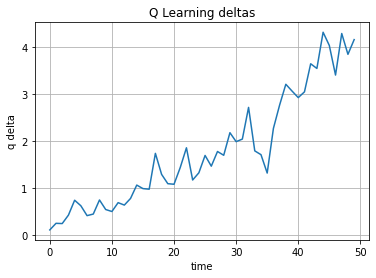

game completed at 2531
game completed at 8582
game completed at 1398

episode 550

you have flag
wait			267.4343
random			246.4257
go_opponent_flag			120.3429
go_team_flag_area			876.5267
go_opponent_flag_carrier			154.2343
go_nearest_opponent			83.8758
go_nearest_teammate			467.1087
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			154.8241
gaurd_teammate_flag_carrier			237.5958
gaurd_team_flag_area			272.9973
guard_opponent_flag_area			156.2650
run_away_from_nearest_opponent			226.3725
run_away_from_opponents_centroid			190.3768

opponent has flag and is close:
wait			-20.9831
random			-23.1113
go_opponent_flag			-97.6599
go_team_flag_area			-48.7969
go_opponent_flag_carrier			0.0013
go_nearest_opponent			-32.5484
go_nearest_teammate			0.8544
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			0.0478
gaurd_teammate_flag_carrier			-53.5853
gaurd_team_flag_area			0.1391
guard_opponent_flag_area			0.2585
run_away_from_nearest_opponent			1.0929
run_awa

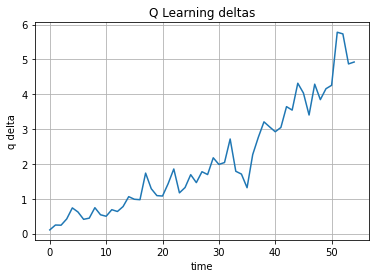

game completed at 7561
game completed at 3627
game completed at 951
game completed at 301
game completed at 9486

episode 600

you have flag
wait			309.3026
random			246.4257
go_opponent_flag			120.3429
go_team_flag_area			1080.2776
go_opponent_flag_carrier			154.2343
go_nearest_opponent			83.8758
go_nearest_teammate			490.4200
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			154.8241
gaurd_teammate_flag_carrier			237.5958
gaurd_team_flag_area			372.2418
guard_opponent_flag_area			156.2650
run_away_from_nearest_opponent			391.9293
run_away_from_opponents_centroid			267.4753

opponent has flag and is close:
wait			-202.3698
random			-13.8165
go_opponent_flag			-57.0051
go_team_flag_area			-28.9836
go_opponent_flag_carrier			-0.0461
go_nearest_opponent			-99.8511
go_nearest_teammate			-99.5650
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			-0.1413
gaurd_teammate_flag_carrier			-35.2912
gaurd_team_flag_area			-0.0874
guard_opponent_flag_area			0.4

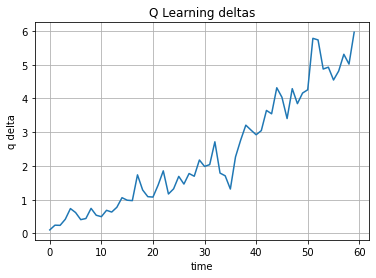

game completed at 1936
game completed at 5339
game completed at 768

episode 650

you have flag
wait			309.3026
random			553.8070
go_opponent_flag			120.3429
go_team_flag_area			1080.2776
go_opponent_flag_carrier			154.2343
go_nearest_opponent			83.8758
go_nearest_teammate			490.4200
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			154.8241
gaurd_teammate_flag_carrier			237.5958
gaurd_team_flag_area			372.2418
guard_opponent_flag_area			156.2650
run_away_from_nearest_opponent			391.9293
run_away_from_opponents_centroid			327.0500

opponent has flag and is close:
wait			-337.5383
random			-10.2729
go_opponent_flag			-41.3427
go_team_flag_area			-21.3297
go_opponent_flag_carrier			-0.1855
go_nearest_opponent			-72.9922
go_nearest_teammate			-72.7835
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			-0.3037
gaurd_teammate_flag_carrier			-28.7177
gaurd_team_flag_area			-0.2644
guard_opponent_flag_area			0.1201
run_away_from_nearest_opponent			-52.9447

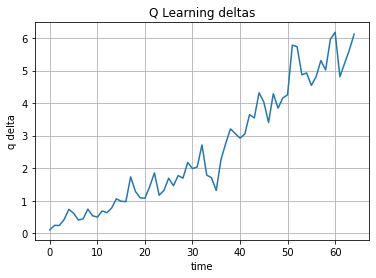

game completed at 545
game completed at 938
game completed at 618
game completed at 192
game completed at 2590

episode 700

you have flag
wait			309.3026
random			553.8070
go_opponent_flag			216.6404
go_team_flag_area			1310.7887
go_opponent_flag_carrier			154.2343
go_nearest_opponent			107.0779
go_nearest_teammate			461.4992
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			225.6639
gaurd_teammate_flag_carrier			306.4300
gaurd_team_flag_area			372.2418
guard_opponent_flag_area			156.2650
run_away_from_nearest_opponent			391.9293
run_away_from_opponents_centroid			453.0079

opponent has flag and is close:
wait			-199.6975
random			-6.4506
go_opponent_flag			-24.4076
go_team_flag_area			-12.9795
go_opponent_flag_carrier			-0.3709
go_nearest_opponent			-43.4857
go_nearest_teammate			-133.2725
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			-0.1702
gaurd_teammate_flag_carrier			-17.3421
gaurd_team_flag_area			-0.5407
guard_opponent_flag_area			-0.3

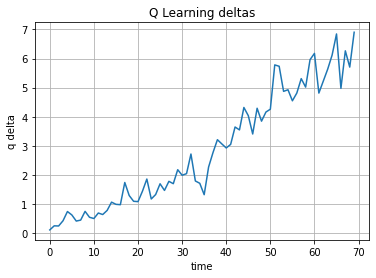

game completed at 1463
game completed at 2579
game completed at 8156
game completed at 2540
game completed at 518
game completed at 363

episode 750

you have flag
wait			455.4877
random			677.0801
go_opponent_flag			321.8932
go_team_flag_area			1456.8814
go_opponent_flag_carrier			243.5740
go_nearest_opponent			107.0779
go_nearest_teammate			559.6974
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			321.1942
gaurd_teammate_flag_carrier			563.6315
gaurd_team_flag_area			439.7807
guard_opponent_flag_area			245.4016
run_away_from_nearest_opponent			463.4022
run_away_from_opponents_centroid			512.4702

opponent has flag and is close:
wait			-106.7586
random			-4.0592
go_opponent_flag			-14.4759
go_team_flag_area			-8.1980
go_opponent_flag_carrier			-0.1053
go_nearest_opponent			-179.1956
go_nearest_teammate			-71.0343
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			-100.6215
gaurd_teammate_flag_carrier			-10.7740
gaurd_team_flag_area			-73.6801
guar

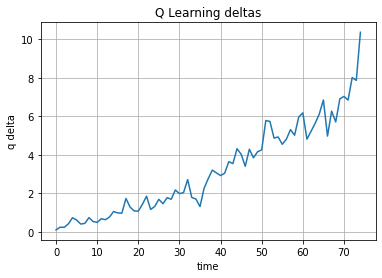

game completed at 1232
game completed at 1333
game completed at 3774
game completed at 2285

episode 800

you have flag
wait			595.8700
random			683.1475
go_opponent_flag			321.8932
go_team_flag_area			1597.1889
go_opponent_flag_carrier			341.3361
go_nearest_opponent			179.8592
go_nearest_teammate			552.7414
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			413.9865
gaurd_teammate_flag_carrier			623.7188
gaurd_team_flag_area			677.5784
guard_opponent_flag_area			420.0313
run_away_from_nearest_opponent			659.0701
run_away_from_opponents_centroid			510.2369

opponent has flag and is close:
wait			-70.5227
random			-3.2042
go_opponent_flag			-8.8871
go_team_flag_area			-5.9196
go_opponent_flag_carrier			-0.2032
go_nearest_opponent			-117.8007
go_nearest_teammate			-47.1466
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			-66.5587
gaurd_teammate_flag_carrier			-98.2306
gaurd_team_flag_area			-48.8824
guard_opponent_flag_area			-1.0643
run_away_from_ne

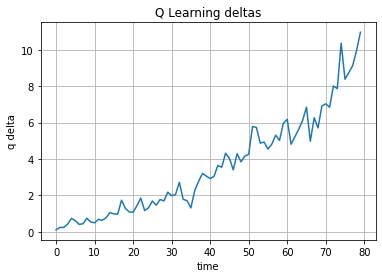

game completed at 1699
game completed at 83
game completed at 1493
game completed at 1819

episode 850

you have flag
wait			663.9581
random			683.1475
go_opponent_flag			321.8932
go_team_flag_area			1597.1889
go_opponent_flag_carrier			341.3361
go_nearest_opponent			424.0471
go_nearest_teammate			625.1424
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			428.7946
gaurd_teammate_flag_carrier			623.7188
gaurd_team_flag_area			981.6112
guard_opponent_flag_area			420.0313
run_away_from_nearest_opponent			776.4295
run_away_from_opponents_centroid			515.4200

opponent has flag and is close:
wait			-46.8098
random			-1.6716
go_opponent_flag			-6.3706
go_team_flag_area			-4.7698
go_opponent_flag_carrier			-0.4853
go_nearest_opponent			-77.8288
go_nearest_teammate			-31.4224
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			-44.2090
gaurd_teammate_flag_carrier			-79.9264
gaurd_team_flag_area			-32.5613
guard_opponent_flag_area			-0.1746
run_away_from_neare

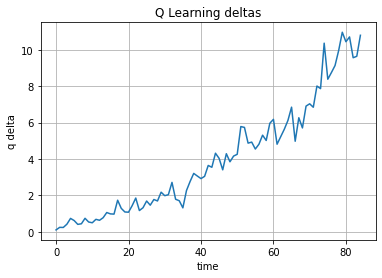

game completed at 938
game completed at 3408
game completed at 4818

episode 900

you have flag
wait			663.9581
random			683.1475
go_opponent_flag			354.6189
go_team_flag_area			1731.9403
go_opponent_flag_carrier			341.3361
go_nearest_opponent			424.0471
go_nearest_teammate			625.1424
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			448.5318
gaurd_teammate_flag_carrier			623.9636
gaurd_team_flag_area			1011.1252
guard_opponent_flag_area			440.6448
run_away_from_nearest_opponent			808.7306
run_away_from_opponents_centroid			515.4200

opponent has flag and is close:
wait			-34.4554
random			-1.5497
go_opponent_flag			-104.1000
go_team_flag_area			-3.8083
go_opponent_flag_carrier			-0.4853
go_nearest_opponent			-57.0683
go_nearest_teammate			-23.2380
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			-32.5594
gaurd_teammate_flag_carrier			-58.5974
gaurd_team_flag_area			-24.0683
guard_opponent_flag_area			-0.4584
run_away_from_nearest_opponent			-32.3

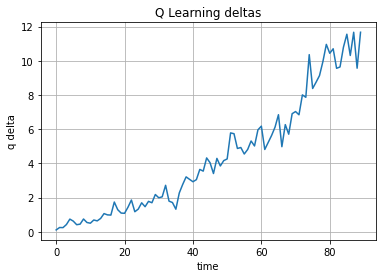

game completed at 6382
game completed at 821
game completed at 8526

episode 950

you have flag
wait			736.0175
random			683.1475
go_opponent_flag			354.6189
go_team_flag_area			1861.3554
go_opponent_flag_carrier			341.3361
go_nearest_opponent			424.0471
go_nearest_teammate			625.1424
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			448.5318
gaurd_teammate_flag_carrier			700.0224
gaurd_team_flag_area			1048.4679
guard_opponent_flag_area			440.6448
run_away_from_nearest_opponent			808.7306
run_away_from_opponents_centroid			528.7931

opponent has flag and is close:
wait			-118.0929
random			-1.5210
go_opponent_flag			-76.2802
go_team_flag_area			-3.1675
go_opponent_flag_carrier			-0.4853
go_nearest_opponent			-41.9941
go_nearest_teammate			-17.3318
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			-24.1271
gaurd_teammate_flag_carrier			-43.1088
gaurd_team_flag_area			-17.9371
guard_opponent_flag_area			-0.7254
run_away_from_nearest_opponent			-23.9

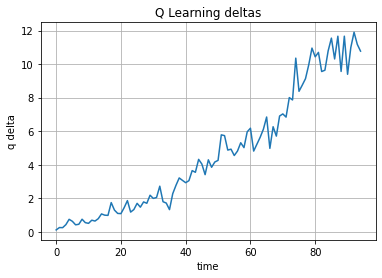

game completed at 1569

episode 1000

you have flag
wait			736.0175
random			683.1475
go_opponent_flag			388.6471
go_team_flag_area			1924.1283
go_opponent_flag_carrier			341.3361
go_nearest_opponent			424.0471
go_nearest_teammate			625.1424
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			448.5318
gaurd_teammate_flag_carrier			700.0224
gaurd_team_flag_area			1048.4679
guard_opponent_flag_area			440.6448
run_away_from_nearest_opponent			797.3475
run_away_from_opponents_centroid			624.7222

opponent has flag and is close:
wait			-206.3417
random			-1.5269
go_opponent_flag			-68.8102
go_team_flag_area			-3.0088
go_opponent_flag_carrier			-0.4853
go_nearest_opponent			-37.9527
go_nearest_teammate			-15.7567
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			-21.8724
gaurd_teammate_flag_carrier			-38.9560
gaurd_team_flag_area			-16.3014
guard_opponent_flag_area			-0.3825
run_away_from_nearest_opponent			-21.7494
run_away_from_opponents_centroid			-110.

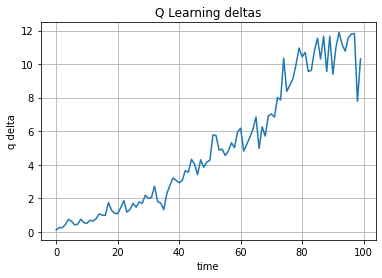

game completed at 9940
game completed at 2272
game completed at 2043

episode 1050

you have flag
wait			816.2460
random			945.7270
go_opponent_flag			535.6265
go_team_flag_area			1924.1283
go_opponent_flag_carrier			341.3361
go_nearest_opponent			535.4727
go_nearest_teammate			637.0638
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			557.5089
gaurd_teammate_flag_carrier			704.4559
gaurd_team_flag_area			1141.5365
guard_opponent_flag_area			471.0160
run_away_from_nearest_opponent			858.6793
run_away_from_opponents_centroid			624.7222

opponent has flag and is close:
wait			-150.7983
random			-1.4883
go_opponent_flag			-50.1978
go_team_flag_area			-2.5686
go_opponent_flag_carrier			-0.6559
go_nearest_opponent			-27.7027
go_nearest_teammate			-11.8618
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			-16.0079
gaurd_teammate_flag_carrier			-31.8099
gaurd_team_flag_area			-12.2589
guard_opponent_flag_area			-0.6541
run_away_from_nearest_opponent			-16

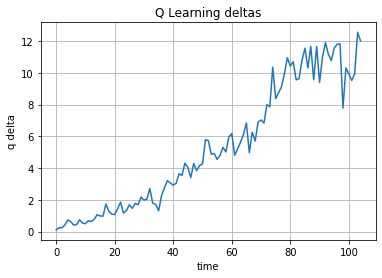

game completed at 709
game completed at 585

episode 1100

you have flag
wait			816.2460
random			945.7270
go_opponent_flag			535.6265
go_team_flag_area			1924.1283
go_opponent_flag_carrier			341.3361
go_nearest_opponent			535.4727
go_nearest_teammate			827.2877
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			557.5089
gaurd_teammate_flag_carrier			708.3908
gaurd_team_flag_area			1141.5365
guard_opponent_flag_area			471.0160
run_away_from_nearest_opponent			858.6793
run_away_from_opponents_centroid			624.7222

opponent has flag and is close:
wait			-122.4430
random			-1.4988
go_opponent_flag			-45.3373
go_team_flag_area			-2.4711
go_opponent_flag_carrier			-0.6559
go_nearest_opponent			-22.7356
go_nearest_teammate			-9.9045
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			-13.2628
gaurd_teammate_flag_carrier			-26.0624
gaurd_team_flag_area			-11.1923
guard_opponent_flag_area			-100.7262
run_away_from_nearest_opponent			-14.7667
run_away_from_oppo

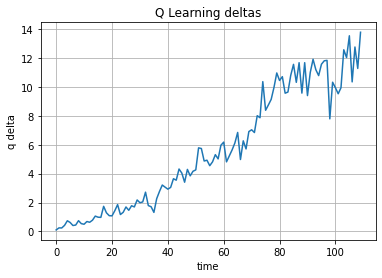

game completed at 3700
game completed at 3063

episode 1150

you have flag
wait			888.4517
random			928.4830
go_opponent_flag			535.6265
go_team_flag_area			1924.1283
go_opponent_flag_carrier			341.3361
go_nearest_opponent			482.4254
go_nearest_teammate			821.8876
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			557.5089
gaurd_teammate_flag_carrier			791.3820
gaurd_team_flag_area			1141.5365
guard_opponent_flag_area			471.0160
run_away_from_nearest_opponent			926.6416
run_away_from_opponents_centroid			624.7222

opponent has flag and is close:
wait			-110.3512
random			-1.5688
go_opponent_flag			-40.9560
go_team_flag_area			-2.3764
go_opponent_flag_carrier			-0.7427
go_nearest_opponent			-20.6819
go_nearest_teammate			-9.0665
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			-12.0890
gaurd_teammate_flag_carrier			-23.6760
gaurd_team_flag_area			-11.1256
guard_opponent_flag_area			-90.8060
run_away_from_nearest_opponent			-13.5100
run_away_from_opp

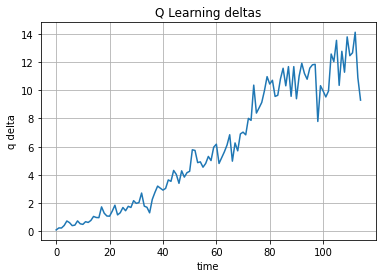

game completed at 1581
game completed at 721
game completed at 2072
game completed at 1459

episode 1200

you have flag
wait			953.4368
random			990.0650
go_opponent_flag			566.8025
go_team_flag_area			1985.6457
go_opponent_flag_carrier			341.3361
go_nearest_opponent			518.9215
go_nearest_teammate			824.4375
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			502.2428
gaurd_teammate_flag_carrier			791.3820
gaurd_team_flag_area			1181.2131
guard_opponent_flag_area			508.6530
run_away_from_nearest_opponent			914.4688
run_away_from_opponents_centroid			798.3025

opponent has flag and is close:
wait			-73.0911
random			-1.3199
go_opponent_flag			-27.1619
go_team_flag_area			-2.2489
go_opponent_flag_carrier			-0.7427
go_nearest_opponent			-13.7701
go_nearest_teammate			-106.5382
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			-8.6213
gaurd_teammate_flag_carrier			-16.2236
gaurd_team_flag_area			-7.9892
guard_opponent_flag_area			-60.2676
run_away_from_n

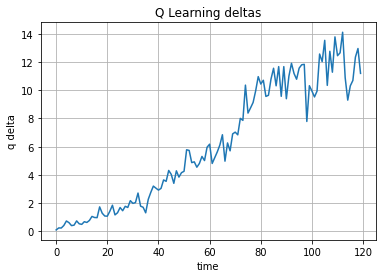

game completed at 4624
game completed at 170
game completed at 1305
game completed at 6297

episode 1250

you have flag
wait			953.4368
random			990.0650
go_opponent_flag			566.8025
go_team_flag_area			2006.9162
go_opponent_flag_carrier			341.3361
go_nearest_opponent			625.7810
go_nearest_teammate			1000.8454
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			612.4718
gaurd_teammate_flag_carrier			791.3820
gaurd_team_flag_area			1360.2124
guard_opponent_flag_area			508.6530
run_away_from_nearest_opponent			914.4688
run_away_from_opponents_centroid			798.3025

opponent has flag and is close:
wait			-134.7379
random			-1.2538
go_opponent_flag			-17.4403
go_team_flag_area			-2.1717
go_opponent_flag_carrier			-0.9113
go_nearest_opponent			-9.7307
go_nearest_teammate			-70.5959
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			-6.3526
gaurd_teammate_flag_carrier			-12.4051
gaurd_team_flag_area			-78.7650
guard_opponent_flag_area			-39.9293
run_away_from_

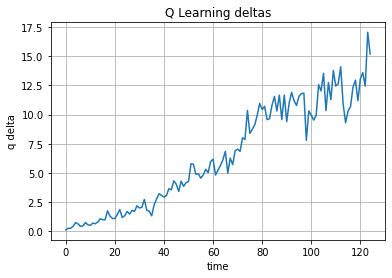

game completed at 500
game completed at 6579
game completed at 869
game completed at 761

episode 1300

you have flag
wait			1023.3353
random			990.0650
go_opponent_flag			566.8025
go_team_flag_area			2125.4423
go_opponent_flag_carrier			472.4447
go_nearest_opponent			646.2368
go_nearest_teammate			983.7948
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			612.4718
gaurd_teammate_flag_carrier			871.4866
gaurd_team_flag_area			1250.9749
guard_opponent_flag_area			508.6530
run_away_from_nearest_opponent			988.2642
run_away_from_opponents_centroid			883.7145

opponent has flag and is close:
wait			-89.0851
random			-1.5061
go_opponent_flag			-12.1261
go_team_flag_area			-2.1083
go_opponent_flag_carrier			-0.9931
go_nearest_opponent			-7.0679
go_nearest_teammate			-47.0015
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			-4.6469
gaurd_teammate_flag_carrier			-9.6060
gaurd_team_flag_area			-52.3612
guard_opponent_flag_area			-26.8811
run_away_from_near

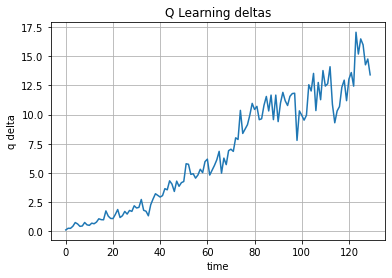

game completed at 2422
game completed at 1430
game completed at 634

episode 1350

you have flag
wait			1090.9372
random			990.0650
go_opponent_flag			591.8714
go_team_flag_area			2125.4423
go_opponent_flag_carrier			472.4447
go_nearest_opponent			751.5485
go_nearest_teammate			1155.4507
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			721.1600
gaurd_teammate_flag_carrier			866.0872
gaurd_team_flag_area			1295.8128
guard_opponent_flag_area			508.6530
run_away_from_nearest_opponent			1123.3712
run_away_from_opponents_centroid			965.2784

opponent has flag and is close:
wait			-65.5566
random			-1.7116
go_opponent_flag			-8.5854
go_team_flag_area			-2.1506
go_opponent_flag_carrier			-1.0732
go_nearest_opponent			-5.7661
go_nearest_teammate			-34.8777
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			-4.0012
gaurd_teammate_flag_carrier			-7.6164
gaurd_team_flag_area			-38.7850
guard_opponent_flag_area			-20.2100
run_away_from_nearest_opponent			-3.60

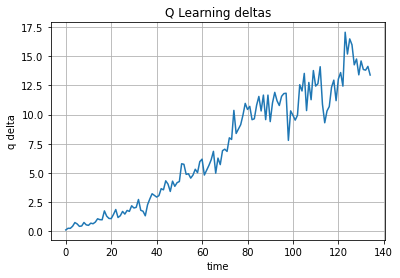

game completed at 746
game completed at 9478
game completed at 2890
game completed at 1179
game completed at 2107
game completed at 3374

episode 1400

you have flag
wait			1090.9372
random			990.7802
go_opponent_flag			633.9409
go_team_flag_area			2056.1882
go_opponent_flag_carrier			472.4447
go_nearest_opponent			696.8253
go_nearest_teammate			1242.0451
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			820.2381
gaurd_teammate_flag_carrier			868.0744
gaurd_team_flag_area			1337.4256
guard_opponent_flag_area			546.3836
run_away_from_nearest_opponent			1099.6300
run_away_from_opponents_centroid			1102.5776

opponent has flag and is close:
wait			-35.8504
random			-1.9205
go_opponent_flag			-3.4334
go_team_flag_area			-2.1538
go_opponent_flag_carrier			-1.2287
go_nearest_opponent			-4.0752
go_nearest_teammate			-19.5464
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			-3.1373
gaurd_teammate_flag_carrier			-64.1156
gaurd_team_flag_area			-21.6228
gua

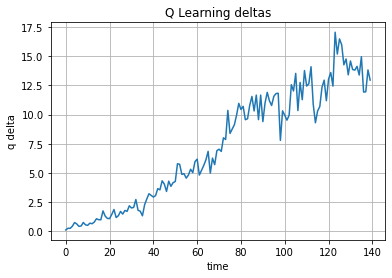

game completed at 111

episode 1450

you have flag
wait			1090.9372
random			990.7802
go_opponent_flag			633.9409
go_team_flag_area			2056.1882
go_opponent_flag_carrier			472.4447
go_nearest_opponent			696.8253
go_nearest_teammate			1242.0451
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			820.2381
gaurd_teammate_flag_carrier			868.0744
gaurd_team_flag_area			1368.0781
guard_opponent_flag_area			546.3836
run_away_from_nearest_opponent			1099.6300
run_away_from_opponents_centroid			1102.5776

opponent has flag and is close:
wait			-35.8504
random			-1.9205
go_opponent_flag			-3.3048
go_team_flag_area			-2.1538
go_opponent_flag_carrier			-1.2287
go_nearest_opponent			-3.8824
go_nearest_teammate			-17.8064
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			-3.0383
gaurd_teammate_flag_carrier			-64.1156
gaurd_team_flag_area			-21.6228
guard_opponent_flag_area			-11.1018
run_away_from_nearest_opponent			-1.5051
run_away_from_opponents_centroid			-54.13

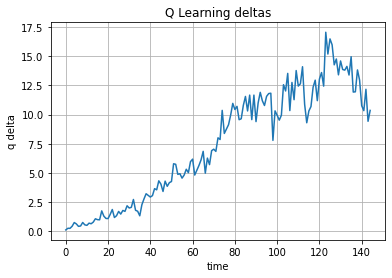

game completed at 2707
game completed at 1696
game completed at 2731
game completed at 1344
game completed at 5414
game completed at 356

episode 1500

you have flag
wait			1200.7198
random			997.1697
go_opponent_flag			708.1298
go_team_flag_area			2072.6631
go_opponent_flag_carrier			472.4447
go_nearest_opponent			696.8253
go_nearest_teammate			1627.7896
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			843.5527
gaurd_teammate_flag_carrier			945.6620
gaurd_team_flag_area			1395.6654
guard_opponent_flag_area			695.8647
run_away_from_nearest_opponent			1099.6300
run_away_from_opponents_centroid			1156.7149

opponent has flag and is close:
wait			-100.8960
random			-1.9311
go_opponent_flag			-2.6667
go_team_flag_area			-2.0551
go_opponent_flag_carrier			-1.4094
go_nearest_opponent			-1.1077
go_nearest_teammate			-10.3735
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			-2.5393
gaurd_teammate_flag_carrier			-34.9983
gaurd_team_flag_area			-12.4017
gu

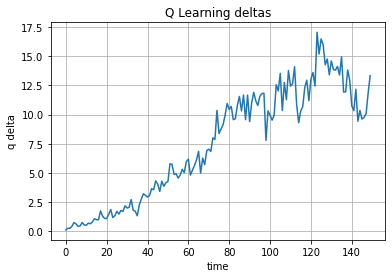

game completed at 1869
game completed at 1721
game completed at 2045

episode 1550

you have flag
wait			1200.7198
random			997.1697
go_opponent_flag			708.1298
go_team_flag_area			2072.6631
go_opponent_flag_carrier			472.4447
go_nearest_opponent			792.8558
go_nearest_teammate			1627.7896
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			943.7954
gaurd_teammate_flag_carrier			1016.8088
gaurd_team_flag_area			1521.9119
guard_opponent_flag_area			734.3299
run_away_from_nearest_opponent			1099.6300
run_away_from_opponents_centroid			1156.7149

opponent has flag and is close:
wait			-73.9510
random			-1.8056
go_opponent_flag			0.2711
go_team_flag_area			-1.8960
go_opponent_flag_carrier			-1.4094
go_nearest_opponent			-1.2053
go_nearest_teammate			-7.9601
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			0.7120
gaurd_teammate_flag_carrier			-25.9116
gaurd_team_flag_area			-9.4387
guard_opponent_flag_area			-5.3626
run_away_from_nearest_opponent			-1.655

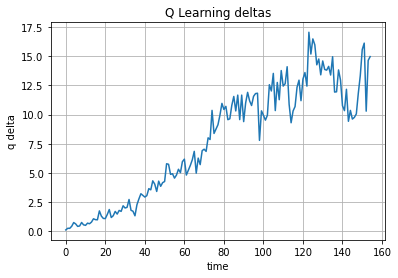


episode 1600

you have flag
wait			1200.7198
random			997.1697
go_opponent_flag			708.1298
go_team_flag_area			2072.6631
go_opponent_flag_carrier			472.4447
go_nearest_opponent			792.8558
go_nearest_teammate			1627.7896
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			943.7954
gaurd_teammate_flag_carrier			1016.8088
gaurd_team_flag_area			1521.9119
guard_opponent_flag_area			734.3299
run_away_from_nearest_opponent			1099.6300
run_away_from_opponents_centroid			1156.7149

opponent has flag and is close:
wait			-73.9510
random			-1.8056
go_opponent_flag			0.2711
go_team_flag_area			-1.8960
go_opponent_flag_carrier			-1.4094
go_nearest_opponent			-1.2053
go_nearest_teammate			-7.9601
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			0.7120
gaurd_teammate_flag_carrier			-25.9116
gaurd_team_flag_area			-9.4387
guard_opponent_flag_area			-5.3626
run_away_from_nearest_opponent			-1.6550
run_away_from_opponents_centroid			-100.3423


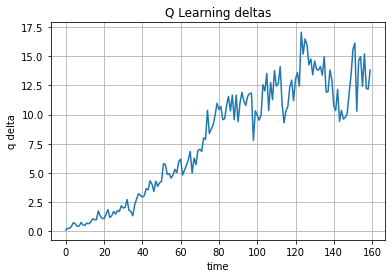

game completed at 825
game completed at 675
game completed at 2272
game completed at 6982

episode 1650

you have flag
wait			1200.7198
random			997.1697
go_opponent_flag			708.1298
go_team_flag_area			2131.2099
go_opponent_flag_carrier			472.4447
go_nearest_opponent			792.8558
go_nearest_teammate			1627.7896
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			943.7954
gaurd_teammate_flag_carrier			1143.1537
gaurd_team_flag_area			1521.9119
guard_opponent_flag_area			831.2937
run_away_from_nearest_opponent			1260.1638
run_away_from_opponents_centroid			1211.4402

opponent has flag and is close:
wait			-48.5904
random			0.8339
go_opponent_flag			-89.8032
go_team_flag_area			-1.3151
go_opponent_flag_carrier			-1.4094
go_nearest_opponent			1.7657
go_nearest_teammate			-5.2938
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			-86.7984
gaurd_teammate_flag_carrier			-17.0717
gaurd_team_flag_area			-6.2638
guard_opponent_flag_area			-3.5895
run_away_from_ne

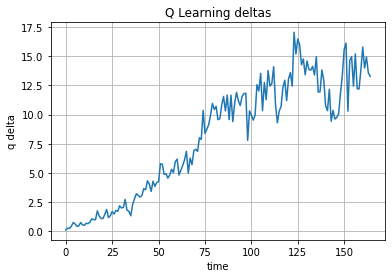

game completed at 521
game completed at 1850
game completed at 1882

episode 1700

you have flag
wait			1296.3370
random			997.1697
go_opponent_flag			708.1298
go_team_flag_area			2131.2099
go_opponent_flag_carrier			472.4447
go_nearest_opponent			792.8558
go_nearest_teammate			1635.4074
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			943.7954
gaurd_teammate_flag_carrier			1143.1537
gaurd_team_flag_area			1521.9119
guard_opponent_flag_area			856.7039
run_away_from_nearest_opponent			1260.1638
run_away_from_opponents_centroid			1211.4402

opponent has flag and is close:
wait			-35.3418
random			0.6885
go_opponent_flag			-65.3859
go_team_flag_area			-0.8781
go_opponent_flag_carrier			-1.2381
go_nearest_opponent			1.3678
go_nearest_teammate			-3.7785
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			-63.1954
gaurd_teammate_flag_carrier			-12.3647
gaurd_team_flag_area			-4.4857
guard_opponent_flag_area			-2.5361
run_away_from_nearest_opponent			-0.85

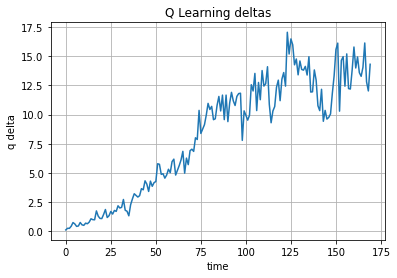

game completed at 182
game completed at 3987
game completed at 66
game completed at 9101
game completed at 1326
game completed at 9574
game completed at 8098

episode 1750

you have flag
wait			1296.3370
random			1274.3831
go_opponent_flag			844.2949
go_team_flag_area			2144.7140
go_opponent_flag_carrier			472.4447
go_nearest_opponent			819.6107
go_nearest_teammate			1647.4535
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			1024.4027
gaurd_teammate_flag_carrier			1143.1537
gaurd_team_flag_area			1655.3136
guard_opponent_flag_area			912.1647
run_away_from_nearest_opponent			1309.1343
run_away_from_opponents_centroid			1240.9825

opponent has flag and is close:
wait			-20.6671
random			-70.5953
go_opponent_flag			-31.7367
go_team_flag_area			-0.1662
go_opponent_flag_carrier			-0.8891
go_nearest_opponent			1.0274
go_nearest_teammate			-2.0294
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			-31.6866
gaurd_teammate_flag_carrier			-7.0994
gaurd_team_

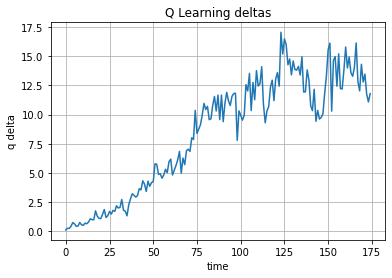

game completed at 894
game completed at 3483

episode 1800

you have flag
wait			1375.8395
random			1418.5219
go_opponent_flag			869.0100
go_team_flag_area			2101.7197
go_opponent_flag_carrier			472.4447
go_nearest_opponent			819.6107
go_nearest_teammate			1647.4535
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			1034.3472
gaurd_teammate_flag_carrier			1143.1537
gaurd_team_flag_area			1655.3136
guard_opponent_flag_area			943.4344
run_away_from_nearest_opponent			1287.3654
run_away_from_opponents_centroid			1288.3613

opponent has flag and is close:
wait			-16.5827
random			-57.0245
go_opponent_flag			-25.5491
go_team_flag_area			0.0231
go_opponent_flag_carrier			-0.8891
go_nearest_opponent			0.9898
go_nearest_teammate			-1.4861
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			-25.5085
gaurd_teammate_flag_carrier			-5.5929
gaurd_team_flag_area			-1.8244
guard_opponent_flag_area			4.6772
run_away_from_nearest_opponent			0.0348
run_away_from_oppone

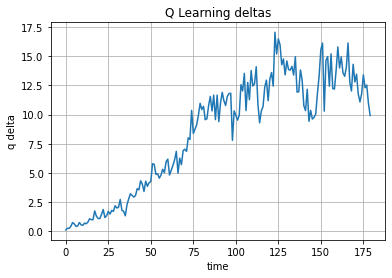

game completed at 4931
game completed at 3457

episode 1850

you have flag
wait			1433.7014
random			1544.8073
go_opponent_flag			889.0607
go_team_flag_area			2101.7197
go_opponent_flag_carrier			472.4447
go_nearest_opponent			928.1788
go_nearest_teammate			1650.7457
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			1034.3472
gaurd_teammate_flag_carrier			1196.8759
gaurd_team_flag_area			1660.0754
guard_opponent_flag_area			943.4344
run_away_from_nearest_opponent			1287.3654
run_away_from_opponents_centroid			1288.3613

opponent has flag and is close:
wait			-12.9266
random			-45.6844
go_opponent_flag			-20.1893
go_team_flag_area			0.5241
go_opponent_flag_carrier			-0.8891
go_nearest_opponent			1.3072
go_nearest_teammate			-0.6983
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			-20.1564
gaurd_teammate_flag_carrier			-4.0248
gaurd_team_flag_area			-0.9723
guard_opponent_flag_area			4.2940
run_away_from_nearest_opponent			0.5336
run_away_from_oppon

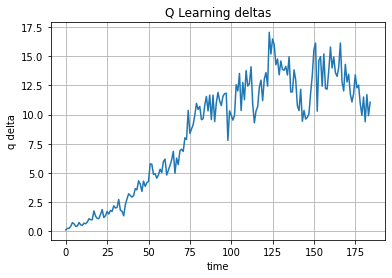

game completed at 5496
game completed at 2337
game completed at 7585
game completed at 4037
game completed at 812
game completed at 1127

episode 1900

you have flag
wait			1433.7014
random			1544.8073
go_opponent_flag			889.0607
go_team_flag_area			2216.4916
go_opponent_flag_carrier			472.4447
go_nearest_opponent			928.1788
go_nearest_teammate			1546.0887
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			1175.5143
gaurd_teammate_flag_carrier			1398.0226
gaurd_team_flag_area			1660.0754
guard_opponent_flag_area			943.4344
run_away_from_nearest_opponent			1287.3654
run_away_from_opponents_centroid			1336.7445

opponent has flag and is close:
wait			-6.3616
random			-27.5074
go_opponent_flag			-99.1654
go_team_flag_area			-63.9635
go_opponent_flag_carrier			1.1189
go_nearest_opponent			2.0433
go_nearest_teammate			2.3613
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			-12.1817
gaurd_teammate_flag_carrier			-1.1051
gaurd_team_flag_area			0.6973
guar

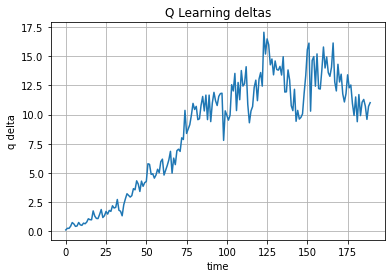

game completed at 2294
game completed at 126
game completed at 2869

episode 1950

you have flag
wait			1433.7014
random			1544.8073
go_opponent_flag			889.0607
go_team_flag_area			2272.1617
go_opponent_flag_carrier			472.4447
go_nearest_opponent			928.1788
go_nearest_teammate			1546.0887
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			1175.5143
gaurd_teammate_flag_carrier			1398.0226
gaurd_team_flag_area			1671.2872
guard_opponent_flag_area			960.2181
run_away_from_nearest_opponent			1287.3654
run_away_from_opponents_centroid			1336.7445

opponent has flag and is close:
wait			-3.5655
random			-18.9808
go_opponent_flag			-71.2195
go_team_flag_area			-45.5573
go_opponent_flag_carrier			1.1189
go_nearest_opponent			2.5617
go_nearest_teammate			2.7934
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			-9.1532
gaurd_teammate_flag_carrier			0.2664
gaurd_team_flag_area			1.5804
guard_opponent_flag_area			6.3860
run_away_from_nearest_opponent			2.3556
r

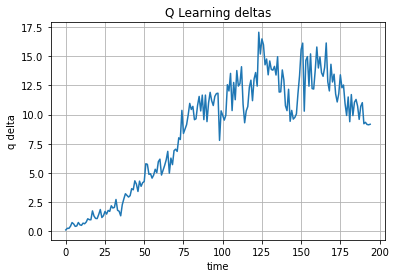

game completed at 3047
game completed at 3845
game completed at 5205

episode 2000

you have flag
wait			1433.7014
random			1672.0995
go_opponent_flag			912.0430
go_team_flag_area			2272.1617
go_opponent_flag_carrier			472.4447
go_nearest_opponent			947.2492
go_nearest_teammate			1546.0887
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			1173.1862
gaurd_teammate_flag_carrier			1398.0226
gaurd_team_flag_area			1671.2872
guard_opponent_flag_area			960.2181
run_away_from_nearest_opponent			1340.3018
run_away_from_opponents_centroid			1314.9584

opponent has flag and is close:
wait			-1.5382
random			-12.7760
go_opponent_flag			-50.8580
go_team_flag_area			-32.1502
go_opponent_flag_carrier			1.3997
go_nearest_opponent			2.9285
go_nearest_teammate			3.0974
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			-5.6117
gaurd_teammate_flag_carrier			1.2552
gaurd_team_flag_area			2.2131
guard_opponent_flag_area			5.7164
run_away_from_nearest_opponent			2.7783


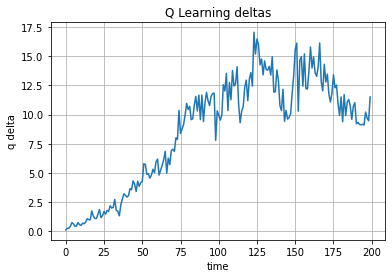

game completed at 7696
game completed at 1359
game completed at 712
game completed at 184
game completed at 1245
game completed at 1284
game completed at 66

episode 2050

you have flag
wait			1510.8412
random			1573.3249
go_opponent_flag			957.6791
go_team_flag_area			2380.1841
go_opponent_flag_carrier			472.4447
go_nearest_opponent			1112.4505
go_nearest_teammate			1546.0887
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			1237.5405
gaurd_teammate_flag_carrier			1439.8933
gaurd_team_flag_area			1901.6811
guard_opponent_flag_area			960.2181
run_away_from_nearest_opponent			1364.3734
run_away_from_opponents_centroid			1418.9367

opponent has flag and is close:
wait			-99.2624
random			-5.3346
go_opponent_flag			-22.2378
go_team_flag_area			-19.9760
go_opponent_flag_carrier			1.5831
go_nearest_opponent			3.0418
go_nearest_teammate			3.1403
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			-0.7538
gaurd_teammate_flag_carrier			1.9414
gaurd_team_flag

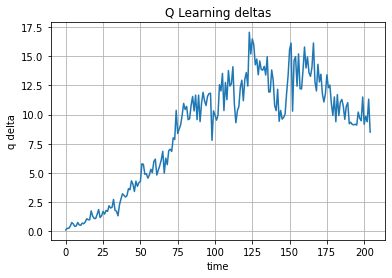

game completed at 313
game completed at 569
game completed at 2034
game completed at 7100
game completed at 1214

episode 2100

you have flag
wait			1597.4515
random			1544.6809
go_opponent_flag			1028.0655
go_team_flag_area			2483.9288
go_opponent_flag_carrier			472.4447
go_nearest_opponent			1129.8939
go_nearest_teammate			1626.0020
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			1242.4749
gaurd_teammate_flag_carrier			1439.8933
gaurd_team_flag_area			1987.2303
guard_opponent_flag_area			1058.7027
run_away_from_nearest_opponent			1364.3734
run_away_from_opponents_centroid			1418.9367

opponent has flag and is close:
wait			-57.6248
random			-2.1614
go_opponent_flag			-10.8931
go_team_flag_area			-10.8070
go_opponent_flag_carrier			1.6541
go_nearest_opponent			2.7847
go_nearest_teammate			-62.7015
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			-80.3755
gaurd_teammate_flag_carrier			2.1349
gaurd_team_flag_area			2.7929
guard_opponent_flag_area

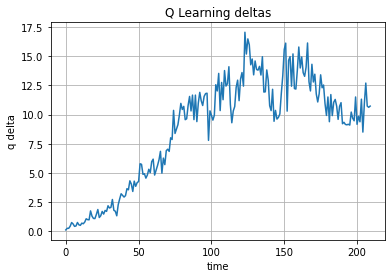

game completed at 389
game completed at 6520
game completed at 763

episode 2150

you have flag
wait			1597.4515
random			1544.6809
go_opponent_flag			1028.0655
go_team_flag_area			2534.2503
go_opponent_flag_carrier			472.4447
go_nearest_opponent			1129.8939
go_nearest_teammate			1766.1418
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			1252.3397
gaurd_teammate_flag_carrier			1439.8933
gaurd_team_flag_area			1991.1473
guard_opponent_flag_area			1086.9447
run_away_from_nearest_opponent			1430.5761
run_away_from_opponents_centroid			1411.1553

opponent has flag and is close:
wait			-41.5099
random			-1.0771
go_opponent_flag			-6.2466
go_team_flag_area			-7.3797
go_opponent_flag_carrier			1.7045
go_nearest_opponent			2.5287
go_nearest_teammate			-45.2108
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			-58.0951
gaurd_teammate_flag_carrier			2.2532
gaurd_team_flag_area			2.5346
guard_opponent_flag_area			-75.0156
run_away_from_nearest_opponent			2.4

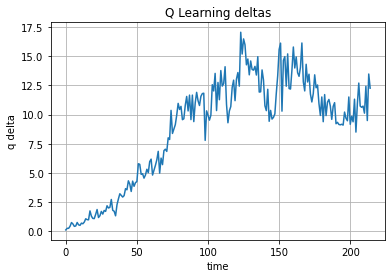

game completed at 870
game completed at 9236
game completed at 326

episode 2200

you have flag
wait			1597.4515
random			1544.6809
go_opponent_flag			1028.0655
go_team_flag_area			2534.2503
go_opponent_flag_carrier			472.4447
go_nearest_opponent			1319.6445
go_nearest_teammate			1723.6399
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			1252.3397
gaurd_teammate_flag_carrier			1439.8933
gaurd_team_flag_area			2097.9454
guard_opponent_flag_area			1112.3625
run_away_from_nearest_opponent			1430.5761
run_away_from_opponents_centroid			1411.1553

opponent has flag and is close:
wait			-30.0169
random			-0.5414
go_opponent_flag			-2.8027
go_team_flag_area			-105.0360
go_opponent_flag_carrier			1.7045
go_nearest_opponent			2.0872
go_nearest_teammate			-31.3305
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			-42.1076
gaurd_teammate_flag_carrier			1.8863
gaurd_team_flag_area			2.0915
guard_opponent_flag_area			-54.4426
run_away_from_nearest_opponent			2

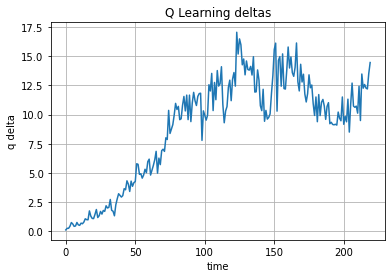

game completed at 4188

episode 2250

you have flag
wait			1640.3464
random			1524.3251
go_opponent_flag			1059.3712
go_team_flag_area			2534.2503
go_opponent_flag_carrier			472.4447
go_nearest_opponent			1321.7924
go_nearest_teammate			1753.9159
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			1252.3397
gaurd_teammate_flag_carrier			1439.8933
gaurd_team_flag_area			2097.9454
guard_opponent_flag_area			1112.3625
run_away_from_nearest_opponent			1430.5761
run_away_from_opponents_centroid			1472.6798

opponent has flag and is close:
wait			-26.9479
random			-0.4199
go_opponent_flag			-2.4551
go_team_flag_area			-94.4651
go_opponent_flag_carrier			1.7045
go_nearest_opponent			1.9458
go_nearest_teammate			-28.1302
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			-37.8295
gaurd_teammate_flag_carrier			1.7650
gaurd_team_flag_area			1.9497
guard_opponent_flag_area			-48.9310
run_away_from_nearest_opponent			1.9204
run_away_from_opponents_centroid			1.03

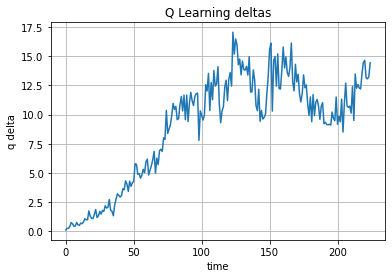

game completed at 3406
game completed at 2664

episode 2300

you have flag
wait			1640.3464
random			1524.3251
go_opponent_flag			1059.3712
go_team_flag_area			2534.2503
go_opponent_flag_carrier			472.4447
go_nearest_opponent			1321.0332
go_nearest_teammate			1670.3700
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			1258.5258
gaurd_teammate_flag_carrier			1439.8933
gaurd_team_flag_area			2090.7909
guard_opponent_flag_area			1132.5463
run_away_from_nearest_opponent			1490.1585
run_away_from_opponents_centroid			1472.6798

opponent has flag and is close:
wait			-21.7326
random			1.1738
go_opponent_flag			-1.8934
go_team_flag_area			-76.4215
go_opponent_flag_carrier			1.7045
go_nearest_opponent			1.6713
go_nearest_teammate			-22.6902
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			-30.5467
gaurd_teammate_flag_carrier			1.5249
gaurd_team_flag_area			1.6745
guard_opponent_flag_area			-39.5389
run_away_from_nearest_opponent			1.6508
run_away_from_opp

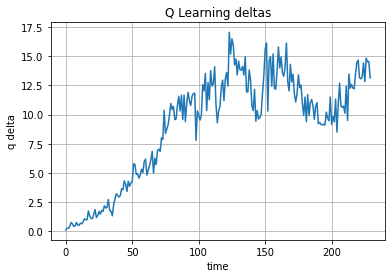

game completed at 785
game completed at 630
game completed at 684
game completed at 744
game completed at 253
game completed at 2092

episode 2350

you have flag
wait			1640.3464
random			1524.3251
go_opponent_flag			1179.0087
go_team_flag_area			2583.5653
go_opponent_flag_carrier			472.4447
go_nearest_opponent			1391.5699
go_nearest_teammate			1677.8629
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			1335.3132
gaurd_teammate_flag_carrier			1439.8933
gaurd_team_flag_area			2084.3518
guard_opponent_flag_area			1192.8182
run_away_from_nearest_opponent			1595.9896
run_away_from_opponents_centroid			1671.9219

opponent has flag and is close:
wait			-11.1673
random			2.8148
go_opponent_flag			1.1848
go_team_flag_area			-40.2312
go_opponent_flag_carrier			3.6719
go_nearest_opponent			3.0792
go_nearest_teammate			-10.1351
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			-14.0427
gaurd_teammate_flag_carrier			-88.5666
gaurd_team_flag_area			1.2722
guard

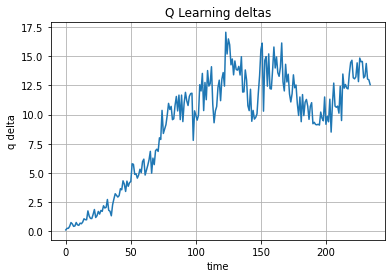

game completed at 3609
game completed at 515
game completed at 257
game completed at 2701
game completed at 7001

episode 2400

you have flag
wait			1640.3464
random			1524.3251
go_opponent_flag			1196.6415
go_team_flag_area			2631.8940
go_opponent_flag_carrier			472.4447
go_nearest_opponent			1391.5699
go_nearest_teammate			1677.8629
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			1335.3132
gaurd_teammate_flag_carrier			1431.4376
gaurd_team_flag_area			2086.6844
guard_opponent_flag_area			1192.8182
run_away_from_nearest_opponent			1595.9896
run_away_from_opponents_centroid			1671.9219

opponent has flag and is close:
wait			-6.4038
random			2.8584
go_opponent_flag			5.2419
go_team_flag_area			-103.4789
go_opponent_flag_carrier			3.5259
go_nearest_opponent			4.7683
go_nearest_teammate			-3.9208
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			-4.5420
gaurd_teammate_flag_carrier			-63.7927
gaurd_team_flag_area			-70.8796
guard_opponent_flag_area	

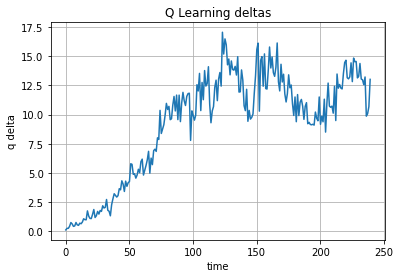

game completed at 5815
game completed at 2804
game completed at 3312
game completed at 78

episode 2450

you have flag
wait			1640.3464
random			1512.2016
go_opponent_flag			1217.2864
go_team_flag_area			2631.8940
go_opponent_flag_carrier			472.4447
go_nearest_opponent			1391.5699
go_nearest_teammate			1650.3856
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			1335.3132
gaurd_teammate_flag_carrier			1431.4376
gaurd_team_flag_area			2088.4675
guard_opponent_flag_area			1192.8182
run_away_from_nearest_opponent			1833.9001
run_away_from_opponents_centroid			1715.1812

opponent has flag and is close:
wait			-75.6522
random			3.2519
go_opponent_flag			6.8024
go_team_flag_area			-66.5160
go_opponent_flag_carrier			3.6118
go_nearest_opponent			4.5050
go_nearest_teammate			-1.1959
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			-2.2966
gaurd_teammate_flag_carrier			-140.3779
gaurd_team_flag_area			-50.6568
guard_opponent_flag_area			-6.8986
run_away_fro

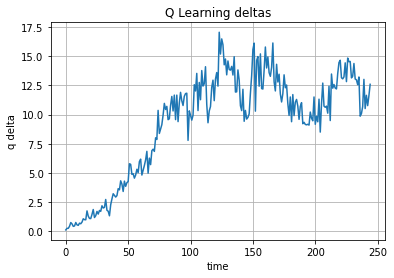

game completed at 88
game completed at 77
game completed at 8786
game completed at 3053
game completed at 246
game completed at 7807
game completed at 1471

episode 2500

you have flag
wait			1697.9043
random			1512.2016
go_opponent_flag			1237.5160
go_team_flag_area			2771.1575
go_opponent_flag_carrier			646.7928
go_nearest_opponent			1391.9610
go_nearest_teammate			1768.2939
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			1671.1118
gaurd_teammate_flag_carrier			1577.2154
gaurd_team_flag_area			2097.5744
guard_opponent_flag_area			1234.9265
run_away_from_nearest_opponent			1791.3829
run_away_from_opponents_centroid			1761.6167

opponent has flag and is close:
wait			-41.9186
random			5.0091
go_opponent_flag			10.6363
go_team_flag_area			-32.1316
go_opponent_flag_carrier			4.1146
go_nearest_opponent			6.0021
go_nearest_teammate			2.0471
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			-48.5887
gaurd_teammate_flag_carrier			-63.6886
gaurd_team_fl

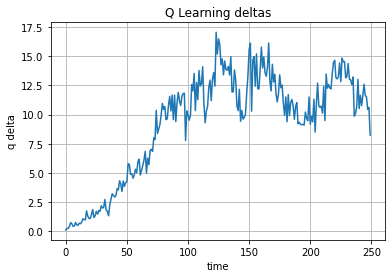

game completed at 4147
game completed at 3488
game completed at 65

episode 2550

you have flag
wait			1697.9043
random			1506.4612
go_opponent_flag			1237.5160
go_team_flag_area			2771.1575
go_opponent_flag_carrier			646.7928
go_nearest_opponent			1391.9610
go_nearest_teammate			1813.6571
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			1671.1118
gaurd_teammate_flag_carrier			1931.4870
gaurd_team_flag_area			2109.4095
guard_opponent_flag_area			1234.9265
run_away_from_nearest_opponent			1833.8372
run_away_from_opponents_centroid			1761.6167

opponent has flag and is close:
wait			-28.2549
random			5.6404
go_opponent_flag			11.8931
go_team_flag_area			-21.1202
go_opponent_flag_carrier			5.9569
go_nearest_opponent			6.6793
go_nearest_teammate			5.3642
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			-37.7739
gaurd_teammate_flag_carrier			-50.0047
gaurd_team_flag_area			-62.7579
guard_opponent_flag_area			-87.5296
run_away_from_nearest_opponent			-

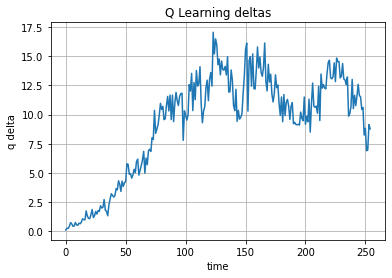

game completed at 4445

episode 2600

you have flag
wait			1697.9043
random			1506.4612
go_opponent_flag			1237.5160
go_team_flag_area			2771.1575
go_opponent_flag_carrier			646.7928
go_nearest_opponent			1391.9610
go_nearest_teammate			1853.8840
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			1671.1118
gaurd_teammate_flag_carrier			1931.4870
gaurd_team_flag_area			2109.4095
guard_opponent_flag_area			1234.9265
run_away_from_nearest_opponent			1833.8372
run_away_from_opponents_centroid			1761.6167

opponent has flag and is close:
wait			-24.5780
random			5.9278
go_opponent_flag			11.5552
go_team_flag_area			-18.1568
go_opponent_flag_carrier			6.2127
go_nearest_opponent			6.8628
go_nearest_teammate			5.6792
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			-33.1450
gaurd_teammate_flag_carrier			-44.1528
gaurd_team_flag_area			-155.5307
guard_opponent_flag_area			-77.9252
run_away_from_nearest_opponent			-24.9949
run_away_from_opponents_centroid			

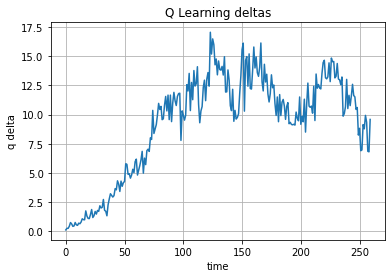

game completed at 66
game completed at 6730
game completed at 2629

episode 2650

you have flag
wait			1753.2726
random			1506.4612
go_opponent_flag			1338.9231
go_team_flag_area			2859.4197
go_opponent_flag_carrier			646.7928
go_nearest_opponent			1262.4045
go_nearest_teammate			1853.8840
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			1650.0222
gaurd_teammate_flag_carrier			1963.4970
gaurd_team_flag_area			2109.4095
guard_opponent_flag_area			1257.4554
run_away_from_nearest_opponent			1875.6122
run_away_from_opponents_centroid			1761.6167

opponent has flag and is close:
wait			-15.7595
random			6.4792
go_opponent_flag			10.5816
go_team_flag_area			-11.0784
go_opponent_flag_carrier			6.6869
go_nearest_opponent			7.1609
go_nearest_teammate			6.2980
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			-22.0048
gaurd_teammate_flag_carrier			-34.2737
gaurd_team_flag_area			-192.1430
guard_opponent_flag_area			-52.9572
run_away_from_nearest_opponent			

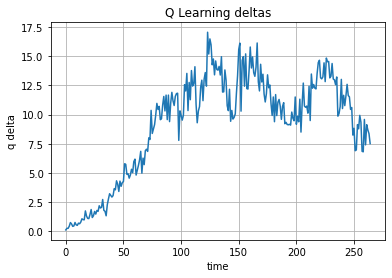

game completed at 765
game completed at 7105
game completed at 3075
game completed at 952

episode 2700

you have flag
wait			1810.0239
random			1578.2933
go_opponent_flag			1338.9231
go_team_flag_area			2944.1867
go_opponent_flag_carrier			646.7928
go_nearest_opponent			1364.8176
go_nearest_teammate			1853.8840
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			1630.1675
gaurd_teammate_flag_carrier			1963.4970
gaurd_team_flag_area			2130.5471
guard_opponent_flag_area			1276.8574
run_away_from_nearest_opponent			1920.1295
run_away_from_opponents_centroid			1817.5336

opponent has flag and is close:
wait			-7.9104
random			7.9970
go_opponent_flag			9.3720
go_team_flag_area			-3.6109
go_opponent_flag_carrier			6.7855
go_nearest_opponent			7.1276
go_nearest_teammate			6.5615
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			-12.0080
gaurd_teammate_flag_carrier			-23.0582
gaurd_team_flag_area			-123.6356
guard_opponent_flag_area			-32.3158
run_away_from

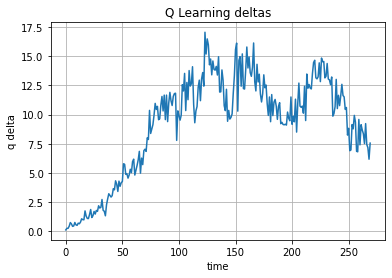

game completed at 658
game completed at 775

episode 2750

you have flag
wait			1810.0239
random			1578.2933
go_opponent_flag			1338.9231
go_team_flag_area			2985.3029
go_opponent_flag_carrier			646.7928
go_nearest_opponent			1364.8176
go_nearest_teammate			1853.8840
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			1630.1675
gaurd_teammate_flag_carrier			1963.4970
gaurd_team_flag_area			2130.5471
guard_opponent_flag_area			1276.8574
run_away_from_nearest_opponent			1920.1295
run_away_from_opponents_centroid			1817.5336

opponent has flag and is close:
wait			-95.1059
random			7.6891
go_opponent_flag			8.8029
go_team_flag_area			-1.7132
go_opponent_flag_carrier			6.7567
go_nearest_opponent			6.9849
go_nearest_teammate			6.5264
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			-8.5149
gaurd_teammate_flag_carrier			-20.1256
gaurd_team_flag_area			-98.9333
guard_opponent_flag_area			-24.9643
run_away_from_nearest_opponent			-4.4580
run_away_from_oppon

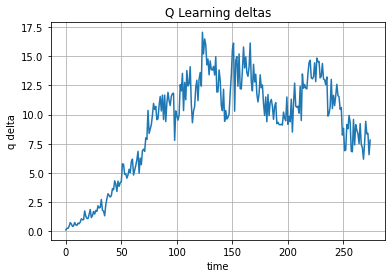

game completed at 938
game completed at 1338
game completed at 1901
game completed at 2807

episode 2800

you have flag
wait			1810.0239
random			1569.6530
go_opponent_flag			1338.9231
go_team_flag_area			3025.5969
go_opponent_flag_carrier			824.0613
go_nearest_opponent			1364.8176
go_nearest_teammate			1853.8840
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			1630.1675
gaurd_teammate_flag_carrier			1963.4970
gaurd_team_flag_area			2130.5471
guard_opponent_flag_area			1298.3607
run_away_from_nearest_opponent			1881.7325
run_away_from_opponents_centroid			1784.9692

opponent has flag and is close:
wait			-60.4432
random			7.0006
go_opponent_flag			7.7313
go_team_flag_area			0.8317
go_opponent_flag_carrier			6.6415
go_nearest_opponent			6.5386
go_nearest_teammate			6.2377
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			-2.6636
gaurd_teammate_flag_carrier			-13.1189
gaurd_team_flag_area			-62.9544
guard_opponent_flag_area			-12.6071
run_away_from_

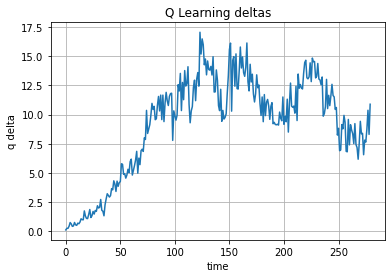

game completed at 7427
game completed at 4895
game completed at 3357

episode 2850

you have flag
wait			1869.2162
random			1757.8945
go_opponent_flag			1357.0147
go_team_flag_area			3003.6833
go_opponent_flag_carrier			824.0613
go_nearest_opponent			1468.5305
go_nearest_teammate			1822.1116
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			1630.1675
gaurd_teammate_flag_carrier			1963.4970
gaurd_team_flag_area			2157.6870
guard_opponent_flag_area			1298.3607
run_away_from_nearest_opponent			1847.1752
run_away_from_opponents_centroid			1760.0883

opponent has flag and is close:
wait			-42.1943
random			6.9722
go_opponent_flag			11.3090
go_team_flag_area			2.4751
go_opponent_flag_carrier			6.8284
go_nearest_opponent			-74.2836
go_nearest_teammate			6.4160
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			-0.0730
gaurd_teammate_flag_carrier			-7.6949
gaurd_team_flag_area			-44.0250
guard_opponent_flag_area			-5.4197
run_away_from_nearest_opponent			3.

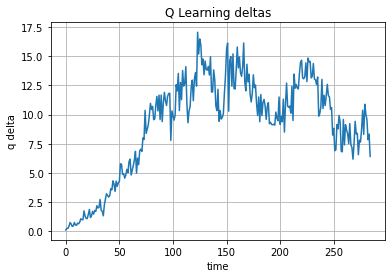

game completed at 1701
game completed at 754
game completed at 2782
game completed at 1819

episode 2900

you have flag
wait			1869.2162
random			1822.2997
go_opponent_flag			1375.9990
go_team_flag_area			2984.6394
go_opponent_flag_carrier			824.0613
go_nearest_opponent			1476.3633
go_nearest_teammate			1822.1116
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			1807.4454
gaurd_teammate_flag_carrier			2005.8185
gaurd_team_flag_area			2157.6870
guard_opponent_flag_area			1298.3607
run_away_from_nearest_opponent			1902.6523
run_away_from_opponents_centroid			1760.0883

opponent has flag and is close:
wait			-25.0606
random			7.1975
go_opponent_flag			10.0429
go_team_flag_area			-76.6720
go_opponent_flag_carrier			-92.8661
go_nearest_opponent			-43.9204
go_nearest_teammate			9.0266
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			2.5384
gaurd_teammate_flag_carrier			-6.1724
gaurd_team_flag_area			-26.2617
guard_opponent_flag_area			3.6502
run_away_fr

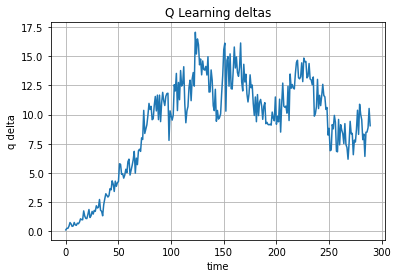

game completed at 452

episode 2950

you have flag
wait			1869.2162
random			1822.2997
go_opponent_flag			1375.9990
go_team_flag_area			2984.6394
go_opponent_flag_carrier			824.0613
go_nearest_opponent			1476.3633
go_nearest_teammate			1978.6716
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			1807.4454
gaurd_teammate_flag_carrier			2005.8185
gaurd_team_flag_area			2157.6870
guard_opponent_flag_area			1298.3607
run_away_from_nearest_opponent			1902.6523
run_away_from_opponents_centroid			1760.0883

opponent has flag and is close:
wait			-121.7511
random			7.1812
go_opponent_flag			9.7421
go_team_flag_area			-68.3014
go_opponent_flag_carrier			-82.8761
go_nearest_opponent			-38.8249
go_nearest_teammate			8.8274
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			2.9880
gaurd_teammate_flag_carrier			-4.8517
gaurd_team_flag_area			-22.9321
guard_opponent_flag_area			3.9886
run_away_from_nearest_opponent			4.8737
run_away_from_opponents_centroid			8.256

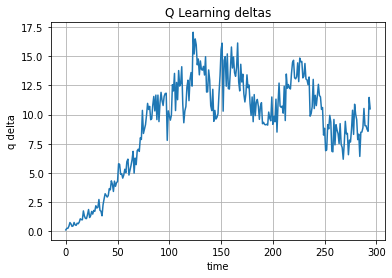

game completed at 2535
game completed at 498

episode 3000

you have flag
wait			1920.9657
random			1822.2997
go_opponent_flag			1375.9990
go_team_flag_area			2984.6394
go_opponent_flag_carrier			824.0613
go_nearest_opponent			1476.3633
go_nearest_teammate			1978.6716
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			1807.4454
gaurd_teammate_flag_carrier			2005.8185
gaurd_team_flag_area			2180.5895
guard_opponent_flag_area			1298.3607
run_away_from_nearest_opponent			1902.6523
run_away_from_opponents_centroid			1760.0883

opponent has flag and is close:
wait			-97.3512
random			7.0840
go_opponent_flag			9.1583
go_team_flag_area			-54.0569
go_opponent_flag_carrier			-73.9091
go_nearest_opponent			-30.1810
go_nearest_teammate			8.4174
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			3.6875
gaurd_teammate_flag_carrier			-2.6627
gaurd_team_flag_area			-17.3078
guard_opponent_flag_area			4.4980
run_away_from_nearest_opponent			8.0192
run_away_from_oppo

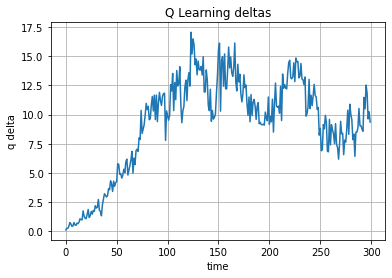

game completed at 1951
game completed at 1028
game completed at 2045
game completed at 1682
game completed at 3924

episode 3050

you have flag
wait			1920.9657
random			1804.6512
go_opponent_flag			1375.9990
go_team_flag_area			3064.4477
go_opponent_flag_carrier			824.0613
go_nearest_opponent			1573.7828
go_nearest_teammate			1945.3859
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			1807.4454
gaurd_teammate_flag_carrier			2043.9078
gaurd_team_flag_area			2207.5864
guard_opponent_flag_area			1333.1061
run_away_from_nearest_opponent			2054.3828
run_away_from_opponents_centroid			1751.5444

opponent has flag and is close:
wait			-54.2980
random			9.9048
go_opponent_flag			10.5582
go_team_flag_area			-28.7332
go_opponent_flag_carrier			-58.3561
go_nearest_opponent			-14.6347
go_nearest_teammate			8.1573
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			7.5022
gaurd_teammate_flag_carrier			0.8887
gaurd_team_flag_area			-7.0332
guard_opponent_flag_are

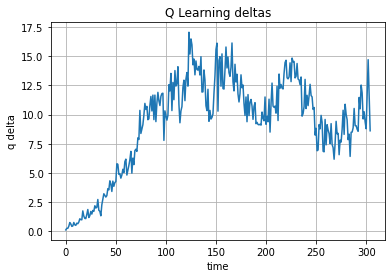

game completed at 357
game completed at 1754
game completed at 1167

episode 3100

you have flag
wait			1977.0218
random			1872.3388
go_opponent_flag			1375.9990
go_team_flag_area			3103.1587
go_opponent_flag_carrier			824.0613
go_nearest_opponent			1664.5572
go_nearest_teammate			1945.3859
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			1807.4454
gaurd_teammate_flag_carrier			2043.9078
gaurd_team_flag_area			2207.5864
guard_opponent_flag_area			1333.1061
run_away_from_nearest_opponent			2054.3828
run_away_from_opponents_centroid			1751.5444

opponent has flag and is close:
wait			-37.6369
random			9.1669
go_opponent_flag			9.6432
go_team_flag_area			-19.0002
go_opponent_flag_carrier			-52.7008
go_nearest_opponent			-8.7224
go_nearest_teammate			7.8930
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			7.4154
gaurd_teammate_flag_carrier			2.5942
gaurd_team_flag_area			-84.0999
guard_opponent_flag_area			8.4640
run_away_from_nearest_opponent			7.72

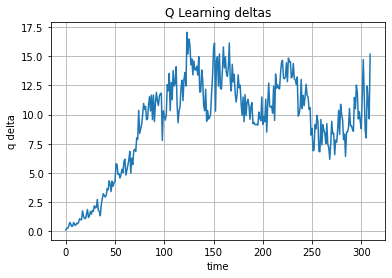

game completed at 1756
game completed at 2201
game completed at 2048
game completed at 1579
game completed at 2559
game completed at 1237

episode 3150

you have flag
wait			2030.5073
random			2093.9509
go_opponent_flag			1589.0843
go_team_flag_area			3178.2736
go_opponent_flag_carrier			992.8428
go_nearest_opponent			1666.3035
go_nearest_teammate			1945.3859
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			1859.9506
gaurd_teammate_flag_carrier			2043.9078
gaurd_team_flag_area			2262.6700
guard_opponent_flag_area			1392.7502
run_away_from_nearest_opponent			2100.1322
run_away_from_opponents_centroid			1751.5444

opponent has flag and is close:
wait			-16.9772
random			7.8963
go_opponent_flag			10.1498
go_team_flag_area			-7.0729
go_opponent_flag_carrier			-41.4793
go_nearest_opponent			-79.2933
go_nearest_teammate			7.2192
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			6.9655
gaurd_teammate_flag_carrier			4.4032
gaurd_team_flag_area			-41.6695


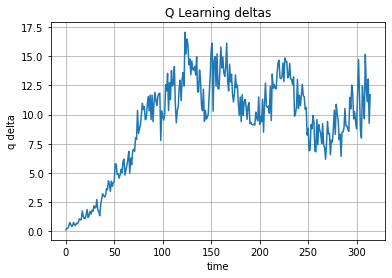

game completed at 4462
game completed at 171

episode 3200

you have flag
wait			2030.5073
random			2052.7579
go_opponent_flag			1598.3779
go_team_flag_area			3178.2736
go_opponent_flag_carrier			1147.7204
go_nearest_opponent			1667.8752
go_nearest_teammate			2105.1092
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			1842.1576
gaurd_teammate_flag_carrier			2043.9078
gaurd_team_flag_area			2262.6700
guard_opponent_flag_area			1421.6772
run_away_from_nearest_opponent			2100.1322
run_away_from_opponents_centroid			1751.5444

opponent has flag and is close:
wait			-12.2662
random			7.8813
go_opponent_flag			11.8071
go_team_flag_area			-4.2437
go_opponent_flag_carrier			-32.1129
go_nearest_opponent			-62.7423
go_nearest_teammate			7.3329
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			7.1274
gaurd_teammate_flag_carrier			4.6749
gaurd_team_flag_area			-32.2670
guard_opponent_flag_area			7.5787
run_away_from_nearest_opponent			-58.2852
run_away_from_op

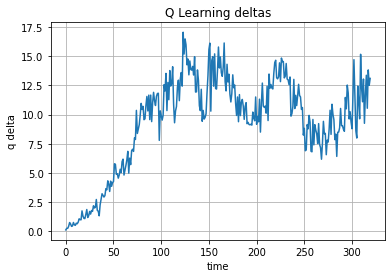

game completed at 732
game completed at 2588

episode 3250

you have flag
wait			2030.5073
random			2052.7579
go_opponent_flag			1598.3779
go_team_flag_area			3178.2736
go_opponent_flag_carrier			1147.7204
go_nearest_opponent			1667.8752
go_nearest_teammate			2148.7602
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			1842.1576
gaurd_teammate_flag_carrier			2043.9078
gaurd_team_flag_area			2262.6700
guard_opponent_flag_area			1421.6772
run_away_from_nearest_opponent			2100.1322
run_away_from_opponents_centroid			1751.5444

opponent has flag and is close:
wait			-8.3578
random			7.9617
go_opponent_flag			11.1416
go_team_flag_area			-1.8596
go_opponent_flag_carrier			-32.1129
go_nearest_opponent			-49.2434
go_nearest_teammate			7.5175
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			7.3510
gaurd_teammate_flag_carrier			5.3645
gaurd_team_flag_area			-24.5585
guard_opponent_flag_area			7.7166
run_away_from_nearest_opponent			-45.6333
run_away_from_opp

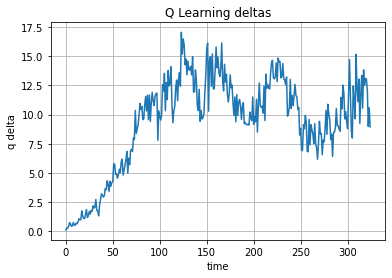

game completed at 5746
game completed at 6585

episode 3300

you have flag
wait			2030.5073
random			2052.7579
go_opponent_flag			1446.7880
go_team_flag_area			3178.2736
go_opponent_flag_carrier			1147.7204
go_nearest_opponent			1667.8752
go_nearest_teammate			2188.0460
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			1842.1576
gaurd_teammate_flag_carrier			2093.6789
gaurd_team_flag_area			2262.6700
guard_opponent_flag_area			1421.6772
run_away_from_nearest_opponent			2100.1322
run_away_from_opponents_centroid			1830.5519

opponent has flag and is close:
wait			-5.2922
random			7.9266
go_opponent_flag			12.1629
go_team_flag_area			-0.0286
go_opponent_flag_carrier			-28.1103
go_nearest_opponent			-38.4095
go_nearest_teammate			7.5668
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			7.4320
gaurd_teammate_flag_carrier			5.5935
gaurd_team_flag_area			-18.4147
guard_opponent_flag_area			7.7281
run_away_from_nearest_opponent			-35.4852
run_away_from_op

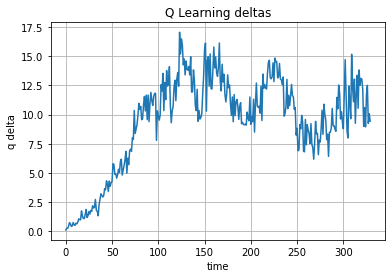

game completed at 816
game completed at 1031

episode 3350

you have flag
wait			2030.5073
random			2052.7579
go_opponent_flag			1470.7773
go_team_flag_area			3178.2736
go_opponent_flag_carrier			1147.7204
go_nearest_opponent			1667.8752
go_nearest_teammate			2188.0460
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			1842.1576
gaurd_teammate_flag_carrier			2093.6789
gaurd_team_flag_area			2290.5649
guard_opponent_flag_area			1421.6772
run_away_from_nearest_opponent			2100.1322
run_away_from_opponents_centroid			1830.5519

opponent has flag and is close:
wait			-2.5358
random			8.0070
go_opponent_flag			14.2929
go_team_flag_area			0.8473
go_opponent_flag_carrier			-28.1103
go_nearest_opponent			-33.6955
go_nearest_teammate			9.2251
go_nearest_incapacitated_teammate			-0.0000
gaurd_nearest_teammate			7.5618
gaurd_teammate_flag_carrier			5.9072
gaurd_team_flag_area			-11.8200
guard_opponent_flag_area			8.0106
run_away_from_nearest_opponent			-26.9922
run_away_from_oppo

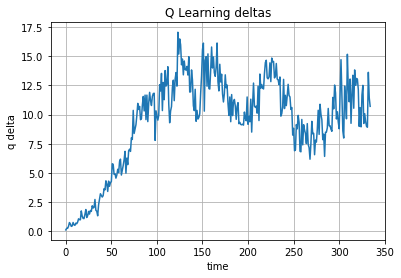

game completed at 5199


KeyboardInterrupt: 

In [112]:
config = Config()
config.blue_team_size = 3
config.red_team_size = 3
trainer = PolicyTrainer(Policy(), config)
trainer.train()

In [43]:

ttl=0
st_cts={}
with open('state_counts.txt') as f:
    f.readline()
    for line in f:
        items = line[:-1].split('\t')
        st = tuple([int(i) for i in items[:-1]])
        ct=int(items[-1])
        ttl+=ct
        st_cts[st]=ct
sorted_states = [(st,st_cts[st]) for st in sorted(st_cts, key=st_cts.get, reverse=True)]

st_probs = {st:ct/ttl for st,ct in sorted_states}
len(st_probs)

In [44]:
import pickle
with open('state_probs.pkl', 'wb') as o:
    pickle.dump(st_probs,o)

In [113]:
q = np.load('q.npy')
print(q.shape)
for i in range(q.shape[0]):
    print('\n')
    hls = []
    for j in range(len(p.high_level_states)):
        #print(i,j)
        if p.high_level_state_codes[i][j]:
            hls.append(p.high_level_states[j])
            
    print(', '.join(hls))
    
    if np.sum(q[i,:])==0:
        print('\tstate never reached')
    else:
        for j in range(len(p.high_level_actions)):
            print('\t%s\t\t\t%.4f' % (p.high_level_actions[j], q[i,j]))

(512, 14)



	wait			837.4832
	random			1059.7192
	go_opponent_flag			1174.5647
	go_team_flag_area			856.6612
	go_opponent_flag_carrier			815.2674
	go_nearest_opponent			1089.3371
	go_nearest_teammate			1001.3095
	go_nearest_incapacitated_teammate			-0.0000
	gaurd_nearest_teammate			1115.8600
	gaurd_teammate_flag_carrier			803.8399
	gaurd_team_flag_area			857.9032
	guard_opponent_flag_area			1098.5205
	run_away_from_nearest_opponent			876.0774
	run_away_from_opponents_centroid			881.1363


nearest_opponent_incapacitated
	wait			-1.5718
	random			-1.6340
	go_opponent_flag			-1.8410
	go_team_flag_area			-1.6190
	go_opponent_flag_carrier			-1.3726
	go_nearest_opponent			-1.6837
	go_nearest_teammate			-1.8550
	go_nearest_incapacitated_teammate			-0.0000
	gaurd_nearest_teammate			-1.8701
	gaurd_teammate_flag_carrier			-1.3881
	gaurd_team_flag_area			-1.4951
	guard_opponent_flag_area			-1.7370
	run_away_from_nearest_opponent			-1.7258
	run_away_from_opponents_centroid			-1.8125


nearest_opp